LUISS Guido Carli Universtity - A.Y. 2023/2024 - Department of Business and Management

Bachelor's Degree in Management and Computer Science - Course of Artificial Intelligence and Machine Learning

Graduation thesis - developed in collaboration with Poste Italiane

# AI-fostered Graph Analysis:
## Network Clustering and Representation Learning

SUPERVISOR: Prof. Giuseppe Francesco Italiano

COMPANY TUTOR: Dott. Lorenzo Gangemi

CANDIDATE: Matteo Spadaccia (ID 277141)

## Implementation in a Business Context
In order to assess AI’s capacities in examining networks in a business context; all the methods theoretically presented in the paper's literature-review section are hereafter applied in analyzing a delivery-logistic sub-graph granted by Poste Italiane.


In [1]:
#   0 - Importing libraries

#%pip install yellowbrick
#%pip install cdlib
import functools as ft
import networkx as nx
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import sklearn.cluster as skCl
import yellowbrick.cluster as ybCl
import matplotlib as mp
import pickle as pkl
import csv
import cdlib as cdl
import hashlib

### 0 - Preliminary analysis
The database’s section in question contains information about the movements of all the shipped packages of a particular Business-service type sent from Lombardia and delivered to Puglia in a specific 2-months period.

In [ ]:
#   0.1 - Probing database

DB = 'datathon.ai_processmining.tracce_l0_pacchi_logistica_pdb'

nEvents = spark.sql(f"SELECT COUNT(*) FROM {DB}").head()[0]
nEntities = spark.sql(f"SELECT COUNT(DISTINCT ID_TRACED_ENTITY) FROM {DB}").head()[0]

print(f"Data on {nEvents} events concerning {nEntities} different entities!")

maskedDF = spark.sql(f"SELECT * FROM {DB}").toPandas()
maskedDF['zipcode'] = maskedDF['zipcode'].astype(str)
for column in ['ID_TRACED_ENTITY', 'WHAT_HAPPENED', 'DESCR_WHAT_HAPPENED', 'tipo', 'vettore_1', 'officename', 'competenza']:
    maskedDF[column] = [hashlib.sha1(str.encode(str(val))).hexdigest() for val in maskedDF[column]]

print("Information structure:\t(with hashed sensible data)")
display(maskedDF.head())
maskedDF.describe(include='all', datetime_is_numeric=True)

Data on 31914 events concerning 1580 different entities!
Information structure:	(with hashed sensible data)


ID_TRACED_ENTITY,WHEN_HAPPENED,ID_CHANNEL,WHAT_HAPPENED,ID_STATUS,MACROESITO,DESCR_WHAT_HAPPENED,FLAG_STATO_FINALE,ANNO,MESE,GIORNO,ORA,tipo,peso,peso_eff,vettore_1,officename,officename_clean,zipcode,competenza,regione,cod_provincia
6ff07293c2e50decd333e19f15343e1b2824b480,2024-03-29T11:19:02Z,07184,71d2961f8c646175d83ad99c25c994314324b16e,Q,IN LAVORAZIONE,5ecc792d97150f5608abd7d0a51caae344c28537,0,2024,3,29,11,521481d2cecfc36226d002e7c094c96bc2e8ed13,700.0,740.0,bdb7708b1819e6dbc983ed3c1dd9129196c8ec2c,0e23d51912a608d9a8fc4c494f9b720167fb5681,CD - BA,70021,3714a556931816b72011fc168acbbe982672506e,Puglia,BA
6ff07293c2e50decd333e19f15343e1b2824b480,2024-03-29T10:17:19Z,07184,f5e39d671a1fdaf60b4ad029eeb4d83633543948,null,IN CONSEGNA,dc854ba0a3588fb417592f57452ca98664e201e6,0,2024,3,29,10,521481d2cecfc36226d002e7c094c96bc2e8ed13,700.0,740.0,bdb7708b1819e6dbc983ed3c1dd9129196c8ec2c,0e23d51912a608d9a8fc4c494f9b720167fb5681,CD - BA,70021,3714a556931816b72011fc168acbbe982672506e,Puglia,BA
6ff07293c2e50decd333e19f15343e1b2824b480,2024-03-29T08:39:21Z,07184,27c002ddc3b27258753b393bee8304ee9ed4d7d8,null,IN LAVORAZIONE,0b97a83fada726479c9a69c5224cb3b493415d7b,0,2024,3,29,8,521481d2cecfc36226d002e7c094c96bc2e8ed13,700.0,740.0,bdb7708b1819e6dbc983ed3c1dd9129196c8ec2c,0e23d51912a608d9a8fc4c494f9b720167fb5681,CD - BA,70021,3714a556931816b72011fc168acbbe982672506e,Puglia,BA
6ff07293c2e50decd333e19f15343e1b2824b480,2024-03-29T08:49:54Z,07184,0e05778b445a5bfc99da49321ed71c061fadffd9,null,IN CONSEGNA,e5840e2b77b9dfdd100b1b8e0b90ea0260ab31d2,0,2024,3,29,8,521481d2cecfc36226d002e7c094c96bc2e8ed13,700.0,740.0,bdb7708b1819e6dbc983ed3c1dd9129196c8ec2c,0e23d51912a608d9a8fc4c494f9b720167fb5681,CD - BA,70021,3714a556931816b72011fc168acbbe982672506e,Puglia,BA
6ff07293c2e50decd333e19f15343e1b2824b480,2024-03-29T08:00:24Z,07184,0e05778b445a5bfc99da49321ed71c061fadffd9,null,IN CONSEGNA,e5840e2b77b9dfdd100b1b8e0b90ea0260ab31d2,0,2024,3,29,8,521481d2cecfc36226d002e7c094c96bc2e8ed13,700.0,740.0,bdb7708b1819e6dbc983ed3c1dd9129196c8ec2c,0e23d51912a608d9a8fc4c494f9b720167fb5681,CD - BA,70021,3714a556931816b72011fc168acbbe982672506e,Puglia,BA


,ID_TRACED_ENTITY,WHEN_HAPPENED,ID_CHANNEL,WHAT_HAPPENED,ID_STATUS,MACROESITO,DESCR_WHAT_HAPPENED,FLAG_STATO_FINALE,ANNO,MESE,GIORNO,ORA,tipo,peso,peso_eff,vettore_1,officename,officename_clean,zipcode,competenza,regione,cod_provincia
count,31914,31914,31914,31914,9805,31681,31914,31914.000000,31914.0,31914.000000,31914.000000,31914.000000,31914,31914,31914.000000,31914,31914,31914,31914,31914,31914,31914
unique,1580,NaN,960,42,42,10,63,NaN,NaN,NaN,NaN,NaN,1,41,NaN,3,935,86,211,12,12,28
top,6ff07293c2e50decd333e19f15343e1b2824b480,NaN,07143,90c595765586e75dce543e6d51c9f8a1010a2217,ICI,IN LAVORAZIONE,4c87a077f9acbd19baf1f61b8916634d3c85bf83,NaN,NaN,NaN,NaN,NaN,521481d2cecfc36226d002e7c094c96bc2e8ed13,500.0,NaN,bdb7708b1819e6dbc983ed3c1dd9129196c8ec2c,7d07d61b065286cd58b0e228d9c2a62860bbccad,CD - BA,70100,24850dc5a04f969c294cf83de52e130ba379c3f6,Puglia,BA
freq,43,NaN,5626,5992,2590,24981,3971,NaN,NaN,NaN,NaN,NaN,31914,15589,NaN,26971,5626,6069,5626,9896,14641,14606
mean,NaN,2024-03-19 14:38:21.350974464,NaN,NaN,NaN,NaN,NaN,0.050605,2024.0,3.073322,16.884032,10.375948,NaN,NaN,995.399511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2024-03-01 08:13:32,NaN,NaN,NaN,NaN,NaN,0.000000,2024.0,3.000000,1.000000,0.000000,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2024-03-12 14:49:24,NaN,NaN,NaN,NaN,NaN,0.000000,2024.0,3.000000,11.000000,6.000000,NaN,NaN,440.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2024-03-19 12:08:56.500000,NaN,NaN,NaN,NaN,NaN,0.000000,2024.0,3.000000,18.000000,10.000000,NaN,NaN,540.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2024-03-26 17:17:35.750000128,NaN,NaN,NaN,NaN,NaN,0.000000,2024.0,3.000000,25.000000,14.000000,NaN,NaN,1000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2024-04-30 11:48:26,NaN,NaN,NaN,NaN,NaN,1.000000,2024.0,4.000000,31.000000,23.000000,NaN,NaN,34800.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Each entity is actually a parcel and information is given about its shipping-type, appointed delivery company, declared and effective weight. Each channel is instead an office through which parcels are worked while proceeding to their delivery point; thus, information is given about its name, the name of the hub of which it is eventually part, its type (e.g., PI center, post office, authorized pick-up point) and location (i.e., Italian Region, District and zip code). Moreover, information about the event – the transition of a package through an office at a determined date and time – is specified in each row; in particular, the events are described both in a coded and explicit way, and the shipping phase is reported.

In [ ]:
#   0.2 - Importing data

DF = spark.sql(f"SELECT * FROM {DB}").toPandas()
DF['zipcode'] = DF['zipcode'].astype(str)

### 1 – Graphs construction
The information is thus translated in network format: an “events” unweighted MultiDiGraph is firstly built, representing offices as nodes and package transitions – obtained grouping rows by entity and ordering the traversed channels based on the datetime value – as edges. Since many events are characterized by a change in shipping status without an actual movement of the package to a different location, self-loops are present in the so-produced graph and are removed to favor the structural cleanness needed for the purpose of analyzing the network from a delivery itinerary viewpoint. Afterwards, a more significant DiGraph is obtained, with the same nodes but with edges’ weight representing the total number of entities which moved from one specific vertex to another. The latter would be called routesG and depicts the parcels’ traffic between offices in a proper way for the subsequent analyses. 


In [3]:
#   1.0 - Preparing graphs' data

nodeAttr = ['officename','officename_clean','zipcode','competenza','regione','cod_provincia']
edgeAttr = ['ID_TRACED_ENTITY','WHEN_HAPPENED','WHAT_HAPPENED','ID_STATUS','MACROESITO','DESCR_WHAT_HAPPENED','peso','peso_eff','vettore_1']

nodesDF = DF[['ID_CHANNEL']+nodeAttr].drop_duplicates()
nodesDF.reset_index(inplace=True)
nodesDF['ID_Node'] = nodesDF.index
nodesDF = nodesDF.drop(columns=['index'])

nodesEncoder = sk.preprocessing.OneHotEncoder(handle_unknown='ignore').fit(nodesDF[nodeAttr])
nodesEncoding = nodesEncoder.transform(nodesDF[nodeAttr])
nodesEncodingDF = pd.DataFrame(nodesEncoding.todense())
nodesEncodingDF.insert(0, 'ID_Node', nodesDF['ID_Node'])

regEncoder = sk.preprocessing.OneHotEncoder(handle_unknown='ignore').fit(nodesDF[['competenza','officename']])
regEncoding = regEncoder.transform(nodesDF[['competenza','officename']])
regLabels, regLabelsDict = pd.factorize(np.array(nodesDF['regione'], dtype='O'), sort=True)

nodesDF = pd.concat([nodesDF, pd.DataFrame({'ID_Node': [len(nodesDF)], 'ID_CHANNEL': ['END'], 'regione': ['END']})], ignore_index=True)
nodeNum = {k:v for k,v in zip(nodesDF.ID_CHANNEL, nodesDF.ID_Node)}
numNode = {v:k for k,v in nodeNum.items()}

edgesDF = DF.drop(columns = nodeAttr).sort_values(['ID_TRACED_ENTITY', 'WHEN_HAPPENED'], ascending=[True, True])
edgesDF['Target_ID_CHANNEL'] = edgesDF.groupby('ID_TRACED_ENTITY')['ID_CHANNEL'].shift(-1, fill_value='END')
edgesDF['ID_Node'] = edgesDF.replace({'ID_CHANNEL': nodeNum})['ID_CHANNEL']
edgesDF['Target_ID_Node'] = edgesDF.replace({'Target_ID_CHANNEL': nodeNum})['Target_ID_CHANNEL']
NSLedgesDF = edgesDF[edgesDF['ID_CHANNEL']!=edgesDF['Target_ID_CHANNEL']]

In [4]:
#   1.1 - Building events network

eventsG = nx.from_pandas_edgelist(edgesDF, 'ID_Node', 'Target_ID_Node', edge_attr=edgeAttr, create_using=nx.MultiDiGraph())
nx.set_node_attributes(eventsG, {node['ID_Node']:{str(col):node[str(col)] for col in nodeAttr} for (i,node) in nodesDF.iterrows()})

NSLeventsG = nx.from_pandas_edgelist(NSLedgesDF, 'ID_Node', 'Target_ID_Node', edge_attr=edgeAttr, create_using=nx.MultiDiGraph())
nx.set_node_attributes(NSLeventsG, {node['ID_Node']:{str(col):node[str(col)] for col in nodeAttr} for (i,node) in nodesDF.iterrows()})

selfLoopsNum = eventsG.number_of_edges() - NSLeventsG.number_of_edges()

eventsG.remove_node(len(nodesDF)-1)
routesMultiG = NSLeventsG.copy()
routesMultiG.remove_node(len(nodesDF)-1)

EventsNodesNum = eventsG.number_of_nodes()
EventsEdgesNum = eventsG.number_of_edges()

print(f"Events network built!\n#Nodes: {EventsNodesNum}\n#Edges: {EventsEdgesNum} (of which {selfLoopsNum} self-loops)")

Events network built!
#Nodes: 960
#Edges: 30334 (of which 20656 self-loops)


In [5]:
#   1.2 - Building routes network

routesDF = NSLedgesDF[['ID_Node','Target_ID_Node','ID_TRACED_ENTITY']].groupby(['ID_Node','Target_ID_Node']).count().reset_index().rename(columns={'ID_Node': 'Source', 'Target_ID_Node':'Target', 'ID_TRACED_ENTITY': 'Traffic'})
routesDF['InvTraffic'] = 1/routesDF['Traffic']

routesG = nx.from_pandas_edgelist(routesDF,source='Source', target='Target', edge_attr=True, create_using=nx.DiGraph())
nx.set_node_attributes(routesG, {node['ID_Node']:{str(col):node[str(col)] for col in nodeAttr} for (i,node) in nodesDF.iterrows()})

routesG.remove_node(nodeNum['END'])

RoutesEdgesNum = routesG.number_of_edges()
RoutesNodesNum = routesG.number_of_nodes()

print(f"Routes network built!\n#Nodes: {RoutesNodesNum}\n#Edges: {RoutesEdgesNum}")

Routes network built!
#Nodes: 960
#Edges: 1385


##### Region-level visualization
A summary is produced grouping the offices by region to have a preliminary cognition of the interconnection framework in question.

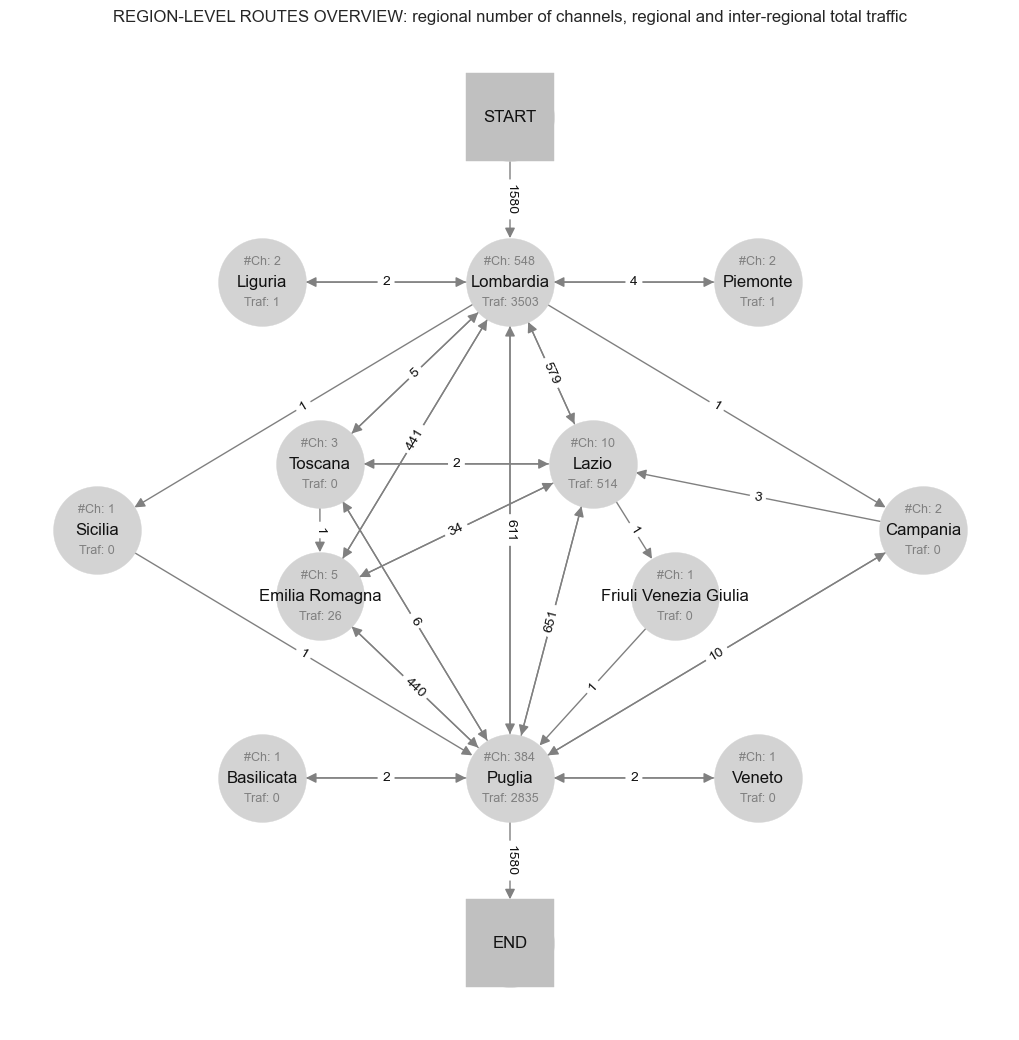

In [7]:
#   1.3 - Drawing region-level routes graph

NSLedgesDFregions = NSLedgesDF.copy()
nodeReg = nodesDF.set_index('ID_Node')['regione'].to_dict()
NSLedgesDFregions.loc[:, 'regione'] = NSLedgesDFregions.loc[:, 'ID_Node'].replace(nodeReg)
NSLedgesDFregions.loc[:, 'Target_regione'] = NSLedgesDFregions.loc[:, 'Target_ID_Node'].replace(nodeReg)

routesDFregions = NSLedgesDFregions[['regione','Target_regione','ID_TRACED_ENTITY']].groupby(['regione','Target_regione']).count().reset_index().rename(columns={'regione': 'Source', 'Target_regione':'Target', 'ID_TRACED_ENTITY': 'Traffic'})

starts = []
for entity in NSLedgesDFregions['ID_TRACED_ENTITY'].unique():
    starts.append(NSLedgesDFregions[NSLedgesDFregions['ID_TRACED_ENTITY'] == entity].iloc[0]['regione'])
if [region for region in starts if region != 'Lombardia'] == []:
    routesDFregions = pd.concat([routesDFregions, pd.DataFrame({'Source':['START'],'Target':['Lombardia'],'Traffic':[len(starts)]})], ignore_index=True)
routesGregions = nx.from_pandas_edgelist(routesDFregions[routesDFregions['Source']!=routesDFregions['Target']],source='Source', target='Target', edge_attr=True, create_using=nx.DiGraph())
nx.set_node_attributes(routesGregions, nodesDF[nodesDF['regione']!='END'][['regione','ID_CHANNEL']].groupby('regione').count().rename(columns={'ID_CHANNEL': '#Channels'}).join(routesDFregions[routesDFregions['Source']==routesDFregions['Target']][['Source','Traffic']].rename(columns={'Traffic': 'Intra-traffic'}).set_index('Source')).replace({np.nan: None}).to_dict('index'))
nx.set_node_attributes(routesGregions, {'START':{'#Channels': None, 'Intra-traffic': None},'END':{'#Channels': None, 'Intra-traffic': None}})

edge_labels=dict([((u,v,),d['Traffic']) for u,v,d in routesGregions.edges(data=True)])
for u,v in edge_labels.keys():
    try: edge_labels[(u,v)]+=routesGregions.edges[(v,u)]['Traffic']
    except: pass
label = lambda d: f"#Ch: {d['#Channels']}\n\n\nTraf: {int(d['Intra-traffic'])}" if d['Intra-traffic']!=None else f"#Ch: {d['#Channels']}\n\n\nTraf: 0" if d['#Channels']!=None else ""
labels = {n:label(d) for n,d in routesGregions.nodes(data=True)}

mp.pyplot.figure(figsize=(10, 10))
pos = {'START':[0,5],'Lombardia':[0,3],'Liguria':[-3,3],'Piemonte':[3,3],'Basilicata':[-3,-3],'Veneto':[3,-3],'Puglia':[0,-3],'END':[0,-5],'Sicilia':[-5,0],'Toscana':[-2.3,0.8],'Emilia Romagna':[-2.3,-0.8],'Lazio':[1,0.8],'Friuli Venezia Giulia':[2,-0.8],'Campania':[5,0]}
nx.draw(routesGregions, pos, with_labels = True, node_color='lightgray', node_size = 4000, edge_color='gray', arrowstyle='-|>', arrowsize=15)
nx.draw_networkx_nodes(routesGregions, pos, nodelist=['START','END'], node_size = 4000, node_shape='s', node_color='silver')
nx.draw_networkx_edge_labels(routesGregions,pos,edge_labels=edge_labels)
nx.draw_networkx_labels(routesGregions,pos,labels=labels,font_color='gray', font_size=9)
mp.pyplot.title("REGION-LEVEL ROUTES OVERVIEW: regional number of channels, regional and inter-regional total traffic")
mp.pyplot.show()

##### Main Regions' subgraphs
Noticing a process-like distribution and previewing the related difficulties for some of the intended algorithms to interpret a similarly ‘linear’ structure, two sub-graphs are built abstracting only nodes from the mainly active Regions (i.e., Lombardia and Puglia). Since no significant output-quality improvement is then noticed applying the clustering methods on these sub-graphs, routesG remained the study’s standard input.

In [9]:
#   1.4 - Generating Lombardia and Puglia subgraphs

lombardiaNodes = [n for n,v in routesG.nodes(data=True) if v['regione'] == 'Lombardia']
lomG = routesG.subgraph(lombardiaNodes)
lomDF = nodesDF[nodesDF['regione'] == 'Lombardia'].copy()
lomDF['lomIndex'] = range(len(lomDF))
lomDF.loc[:, 'lomIndex'] = range(len(lomDF))
nodeLom = lomDF.set_index('ID_Node')['lomIndex'].to_dict()
lomNode = {v:k for k,v in nodeLom.items()}
lomG = nx.relabel_nodes(lomG,nodeLom)
lomDF['in'] = lomDF['lomIndex'].transform(lambda x: lomG.in_degree(x))
lomDF['out'] = lomDF['lomIndex'].transform(lambda x: lomG.out_degree(x))
lomDF['deg'] = lomDF['in'] + lomDF['out']

pugliaNodes = [n for n,v in routesG.nodes(data=True) if v['regione'] == 'Puglia']
pugG = routesG.subgraph(pugliaNodes)
pugDF = nodesDF[nodesDF['regione'] == 'Puglia'].copy()
pugDF.loc[:, 'pugIndex'] = range(len(pugDF))
nodePug = pugDF.set_index('ID_Node')['pugIndex'].to_dict()
pugNode = {v:k for k,v in nodePug.items()}
pugG = nx.relabel_nodes(pugG,nodePug)
pugDF['in'] = pugDF['pugIndex'].transform(lambda x: pugG.in_degree(x))
pugDF['out'] = pugDF['pugIndex'].transform(lambda x: pugG.out_degree(x))
pugDF['deg'] = pugDF['in'] + pugDF['out']

### 2 - Network clustering
Hereafter, all the methods discussed in the thesis' literature-review section are applied on routesG with the aim of probing its nodes’ characteristics. Specifically, channels are analyzed and grouped in clusters through the different proposed algorithms firstly based on nodes’ attributes only, then on the whole graph structure only, and finally leveraging both the information sets. To do so, the previously introduced representation-learning strategies are exploited too, generating embeddings from the relevant data and applying K-means clustering on them. Being most of the algorithms non-deterministic, a seed value is used throughout the procedure to generate significant but constant outputs, since testing via multiple iterations without applying the latter de-randomization technique led to very slight results variations in terms of nodes partition and subsequent clustering’s quality.

In order to assess the properties of the resulting communities sets, two functions are defined: one studying the input clustering’s quality considering the relevant network structure - applying all the graph-based metrics already discussed (i.e., Cov, SCM, TS, Q, AC) – and one testing the exactness of the partitioning with respect to a given classification (e.g., another already generated clustering or a ground-truth set of communities) – computing all the above presented label-based indexes (i.e., Acc, J, FM, ARI, NMI, F1). A function is specially prepared to calculate the traffic-aware performance TS, obviating its absence in standard python libraries.


In [11]:
#   2.0 - Defining clusterings-evalution dataframes and functions

clusteringsDF = nodesDF.drop(len(nodesDF)-1)
clusteringsQualityDF = pd.DataFrame(columns=['ALGORITHM','#Clusters','Cov','SCM','TS','Q','AC'])

def LCP(labels = None, clustering = None, partition = None):
    '''
    Function to translate among labels, clustering and partition objects
    (nodes must be a series of successive integers starting from 0)
    '''
    try:
        if labels == None:
            labNotNone = False
        else:
            labNotNone = True
    except:
        labNotNone = True
    if labNotNone:
        Nlabels = max(labels)+1
        nodes = range(len(labels))
        clustering = [[node for node in nodes if labels[node]==label] for label in range(Nlabels)]
        partition = {node:labels[node] for node in nodes}
    
    elif clustering != None:
        Nlabels = len(clustering)
        nodes = range(ft.reduce(lambda count, l: count + len(l), clustering, 0))
        labels = np.array([cluster for node in nodes for cluster in range(Nlabels) if node in clustering[cluster]])
        partition = {node:labels[node] for node in nodes}

    elif partition != None:
        nodes = sorted(list(partition.keys()))
        labels = np.array([partition[node] for node in nodes])
        Nlabels = max(labels)+1
        clustering = [[node for node in nodes if labels[node]==label] for label in range(Nlabels)]

    return labels, clustering, partition

def TASCM(G,partition,weight,percentile=98):
    import math
    '''
    Function to compute the Traffic-aware Scaled Coverage Measure (TS)
    '''
    labels,clustering,partition = LCP(partition=partition)
    X = nx.adjacency_matrix(G, weight=weight).toarray()

    Xp = min([x for x in np.percentile(X, percentile, axis=1) if x != 0])
    minusAlpha = (-1/Xp)*math.log((1+percentile/100)/(1-percentile/100))
    V = (2/(1+math.e**(minusAlpha*X)))-1
    
    nodes = range(len(labels))
    W = []
    Z = []
    for node in nodes:
        intraCluster = set(clustering[partition[node]])-{node}
        extraCluster = set(nodes)-intraCluster-{node}
        W.append(0)
        Z.append(0)
        for intraClusterNode in intraCluster:
            W[node] += 1-V[node,intraClusterNode]
        for extraClusterNode in extraCluster:
            Z[node] += V[node,extraClusterNode]
    W,Z = np.array(W),np.array(Z)

    TS = 1 - (W+Z)/(len(nodes)-1)
    avgTS = np.average(TS)
    
    return avgTS

def clustering_evaluation(G, partition, weight = None, IO = True):
    '''
    Function to evaluate clusterings thorugh different graph-based metrics
    '''    
    if weight != None:  # Building MuliDiGraph with multi-edges instead of traffic (useful for Coverage and Average Conductance functions)
        MEG = nx.MultiDiGraph(G)
        for u,v,d in G.edges(data = True):
            for i in range(d[weight]-1):
                MEG.add_edge(u,v)
    else:
        MEG = G
    
    labels,clustering,partition = LCP(partition=partition)

    cdlNC = cdl.NodeClustering(clustering, G)
    MEcdlNC = cdl.NodeClustering(clustering, MEG)

    Cov = nx.community.partition_quality(MEG, clustering)[0]
    SCM = nx.community.partition_quality(G, clustering)[1]
    TS = TASCM(G,partition,weight)
    Q = nx.community.modularity(G, clustering, weight=weight)
    AC = MEcdlNC.conductance().score

    if IO:
        print(f"Clustering evaluation:\n#Communities: {len(clustering)}\nCoverage: {Cov}\nPerformance: {SCM}\nTraffic-aware Perf.: {TS}\nModularity: {Q}\nAvg.Conductance: {AC}\n")

    return len(clustering),Cov,SCM,TS,Q,AC

def classification_evaluation(G, partition, classification, weight = None, IO = True):
    '''
    Function to evaluate clusterings thorugh different label-based metrics
    '''   
    labels,clustering,partition = LCP(partition=partition)
    Clabels,Cclustering,Cpartition = LCP(partition=classification)
    assert len(labels) == len(Clabels)

    cdlNC = cdl.NodeClustering(clustering, G)
    CcdlNC = cdl.NodeClustering(Cclustering, G)

    Acc = sum(labels==Clabels)/len(labels)
    J = sk.metrics.jaccard_score(labels, Clabels, average='micro')
    FM = sk.metrics.fowlkes_mallows_score(labels, Clabels)
    ARI = cdlNC.adjusted_rand_index(CcdlNC).score
    NMI =  cdlNC.normalized_mutual_information(CcdlNC).score
    F1 = cdlNC.f1(CcdlNC).score

    if IO:
        print(f"Classification evaluation:\nAccuracy: {Acc}\nJaccard: {J}\nFowlkes-Mallows: {FM}\nAdj.RandIdx.: {ARI}\nNorm.MutualInf.: {NMI}\nF1-score: {F1}\n")

    return Acc,J,FM,ARI,NMI,F1

#### 2.0 - Number of clusters choice
As some of the intended algorithms need the desired number of communities k to be chosen, the theoretically presented ad-hoc strategies are applied, conceiving features’ K-means clustering as a baseline method.

##### (EM) – Elbow Method
The k-dependent trend is studied for communities’ number up to 30 via three clustering quality scores: Distortion, Calinski-Harabasz and Silhouette.

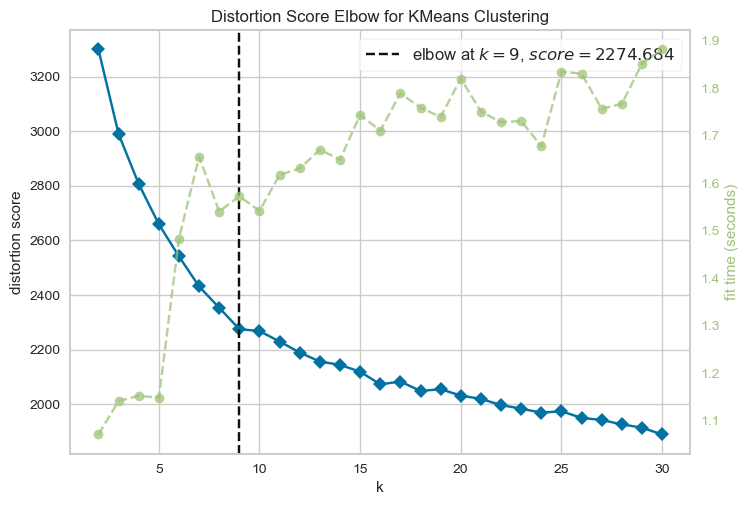

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [78]:
#   2.0.1 - Elbow-method with Distortion score

visualizer = ybCl.KElbowVisualizer(skCl.KMeans(), k=30, timings= True)
visualizer.fit(nodesEncoding.toarray())
visualizer.show()

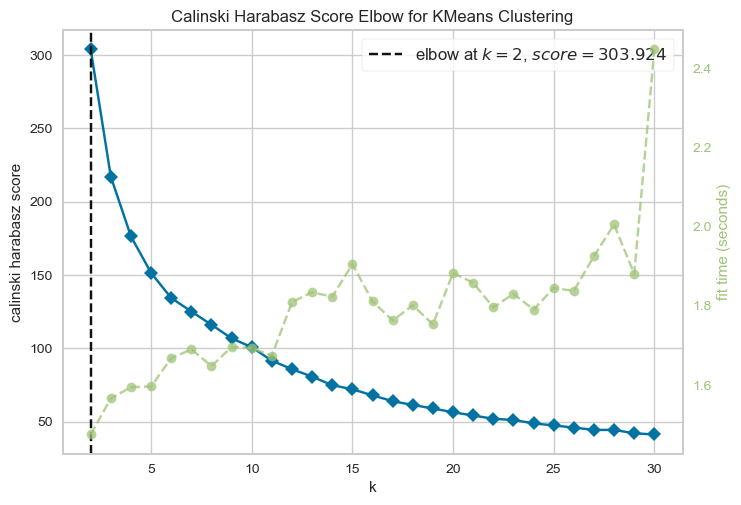

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [15]:
#   2.0.2 - Elbow-method with Calinski-Harabasz score

visualizer = ybCl.KElbowVisualizer(skCl.KMeans(), k=30, timings= True, metric='calinski_harabasz')
visualizer.fit(nodesEncoding.toarray())
visualizer.show()

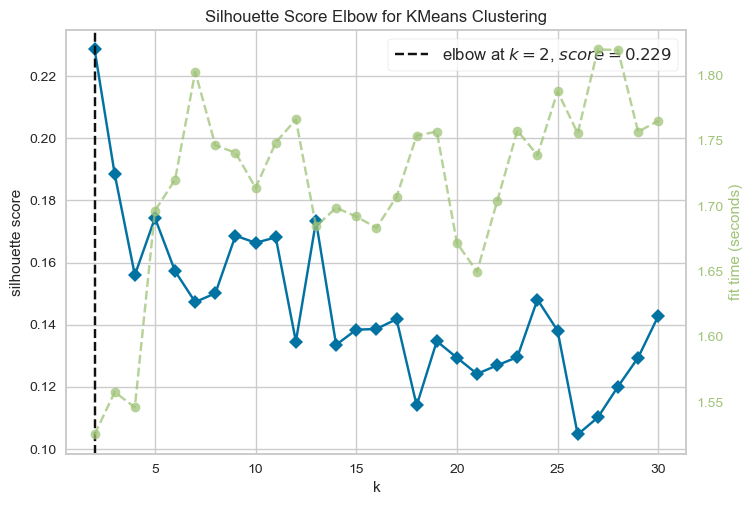

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [16]:
#   2.0.3 - Elbow-method with silhouette score

visualizer = ybCl.KElbowVisualizer(skCl.KMeans(), k=30, timings= True, metric='silhouette')
visualizer.fit(nodesEncoding.toarray())
visualizer.show()

Suggesting that a significant k based on nodes’ attributes would be to choose around 9 or around 2, the Elbow Method’s outcomes are not surprising at all. In fact, channels’ features are only six, all categorical, and four of them (i.e., officename, officename_clean, cod_provincia, zipcode) have an excessively high number of possible values to be considered as particularly relevant by a clustering algorithm. Therefore, only two attributes remain possibly leading in determining each office’s allocation to a community: competenza – with only 9 over the 12 possible categories being consistently represented – and regione – depicting a distribution explained at 97% just by Lombardia and Puglia comparably-sized groups of channels.

##### (GS) – Gap Statistic
Considering the low score increments at k higher than 3, the Gap Statistic’s results seem to confirm that priority should be given to values around 2 rather than 9 when choosing the clusters’ number.

15


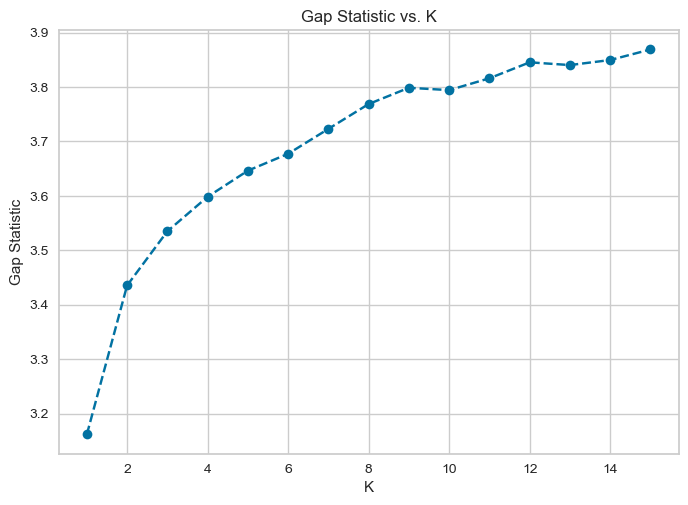

In [19]:
#   2.0.4 - Gap Statistic

def Gap_Statistic(data, nrefs, maxClusters):
    '''
    Function to Gap-Statistic analyze K-means clustered data based on nrefs sample reference datasets
    '''
    gaps = np.zeros((len(range(1, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters+1)):
        refDisps = np.zeros(nrefs)
        for i in range(nrefs):
            
            randomReference = np.random.random_sample(size=data.shape)
            
            km = skCl.KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        
        km = skCl.KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        gaps[gap_index] = gap
        
        resultsdf = pd.concat([resultsdf,pd.DataFrame({'clusterCount':[k], 'gap':[gap]})], ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)


score_g, df = Gap_Statistic(nodesEncoding, 3, 15)
print(score_g)
mp.pyplot.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b')
mp.pyplot.xlabel('K')
mp.pyplot.ylabel('Gap Statistic')
mp.pyplot.title('Gap Statistic vs. K')
mp.pyplot.show()

##### (SA) – Silhouette Analysis
Generating visualizations of silhouette multiple distributions for each different k value up to 15, no doubt is raisable about the consistency of 2 as number of clusters to pass as relevant algorithms’ input. In fact, the visualizations well express the less coherent communities’ size distribution and the under-average scores typical of clusterings in more than 2 – and particularly in around 9 – communities.

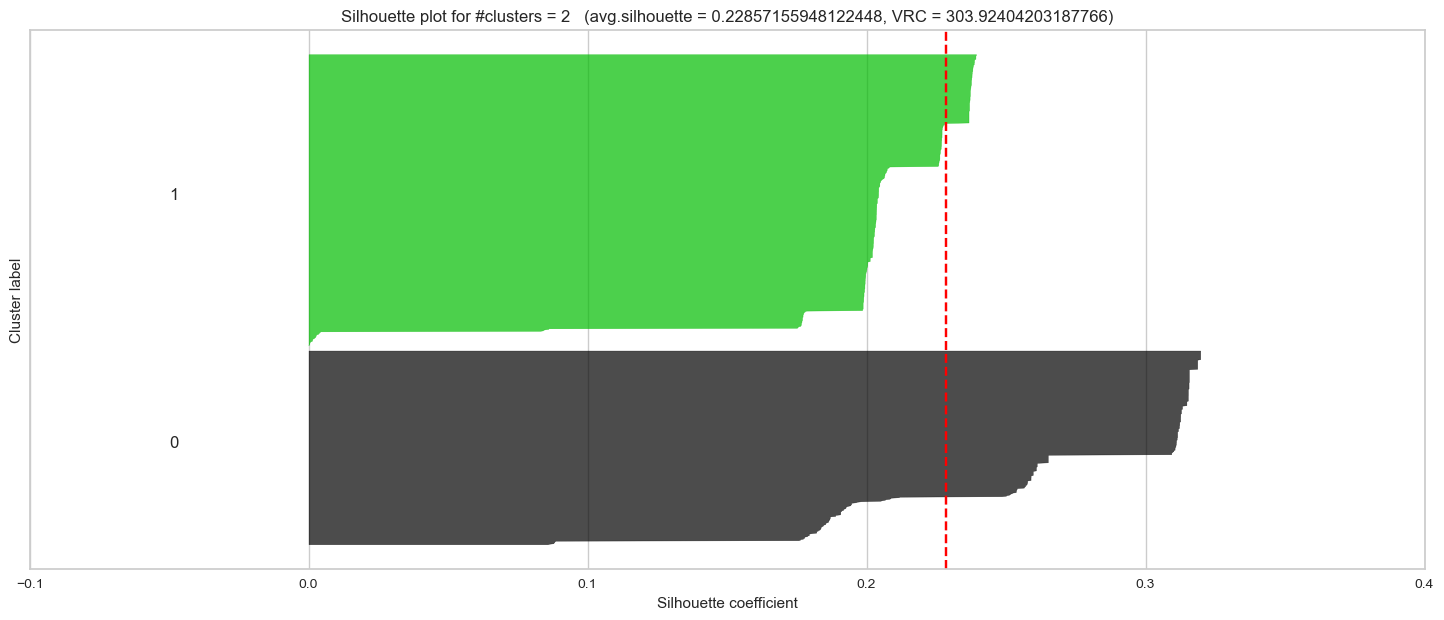

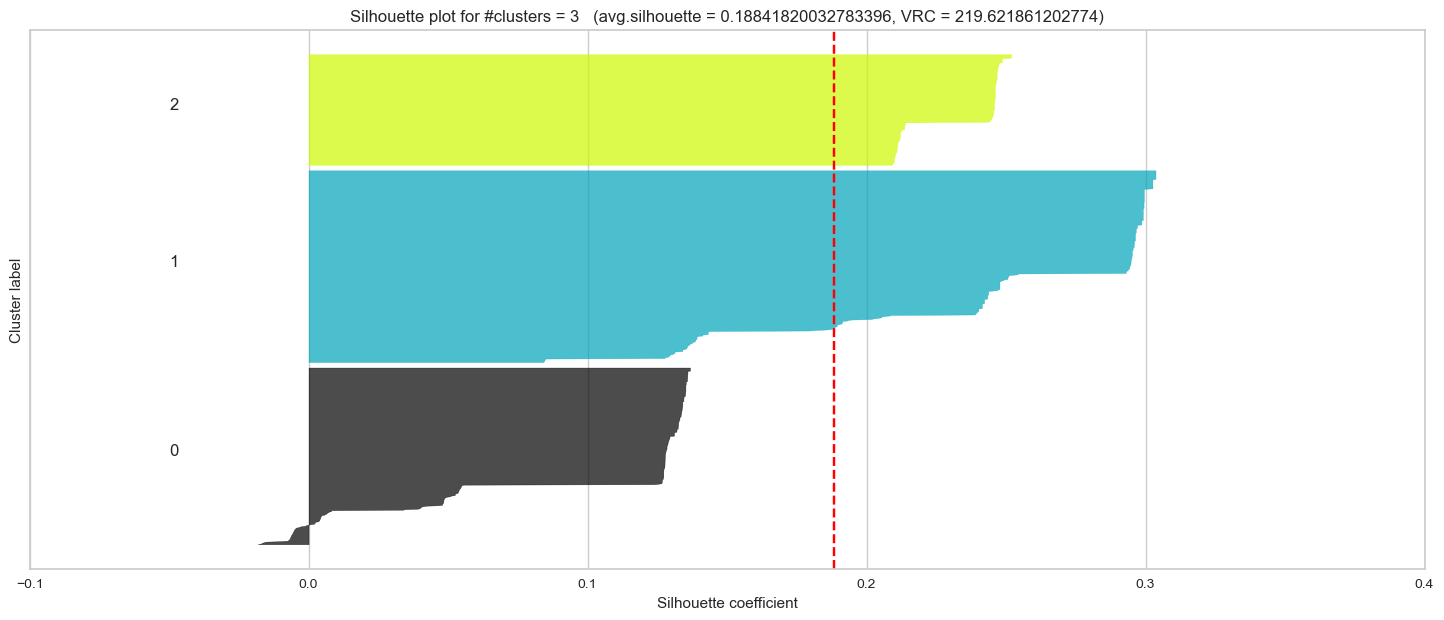

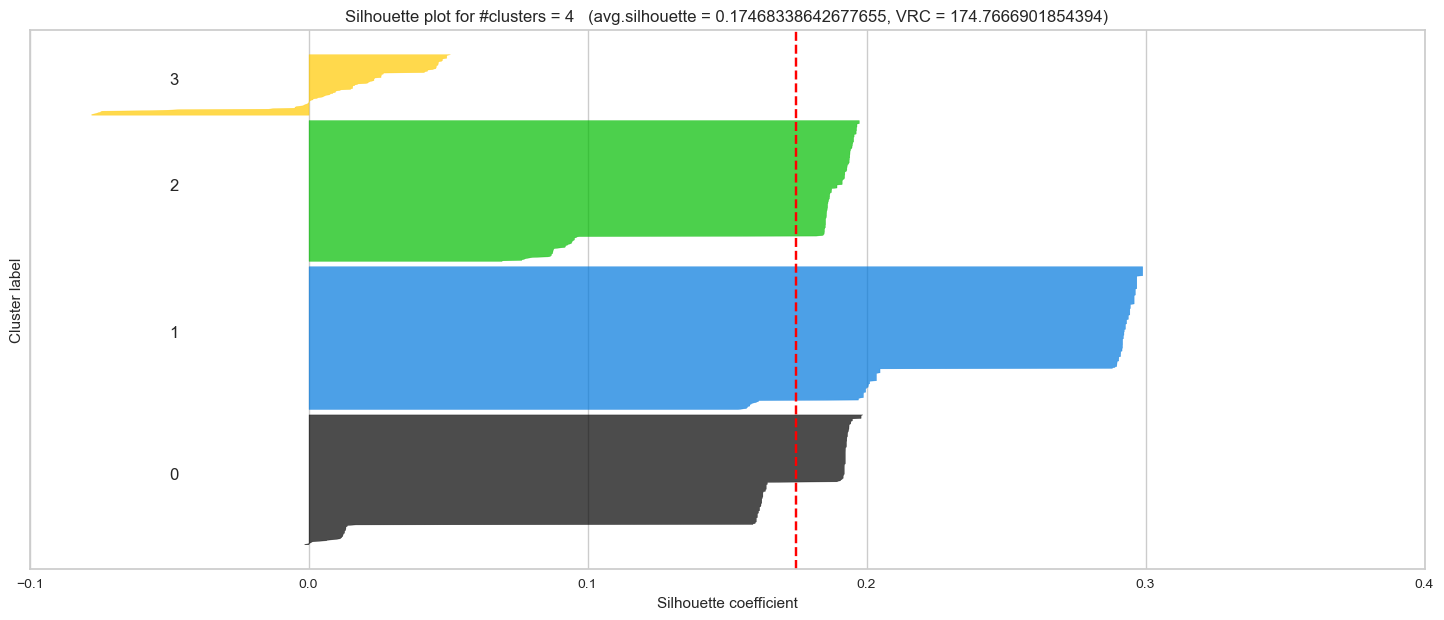

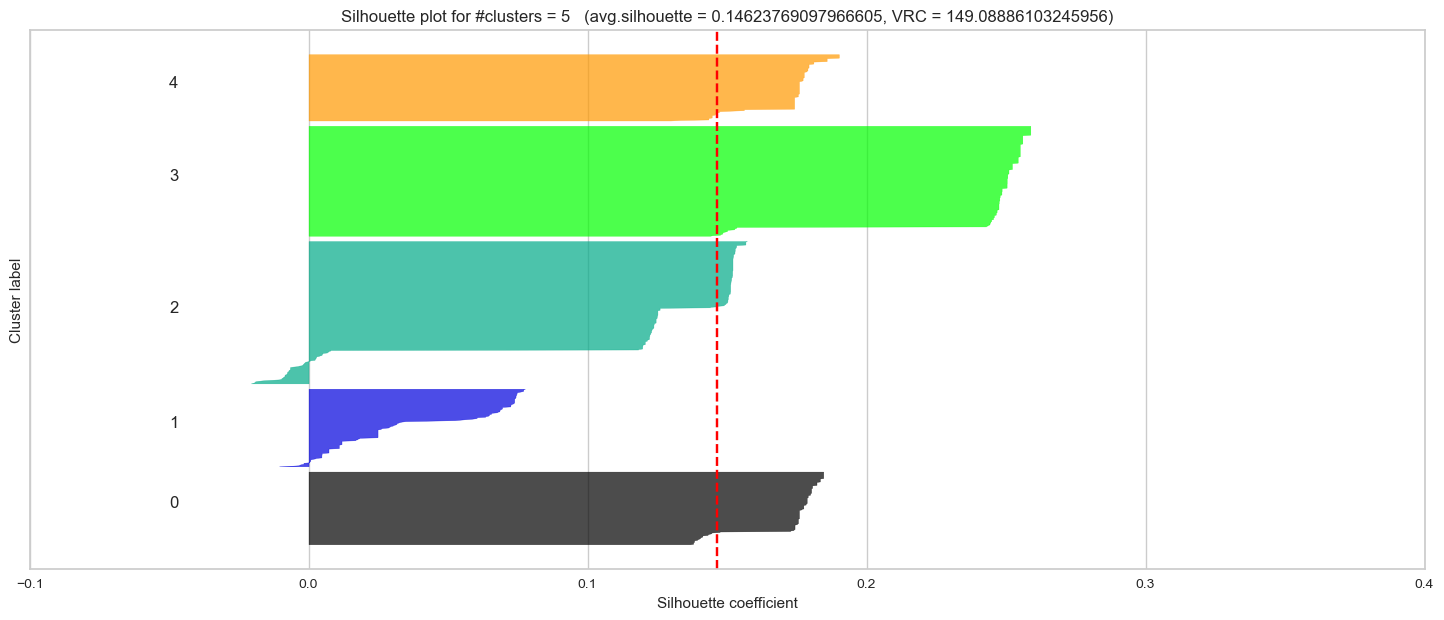

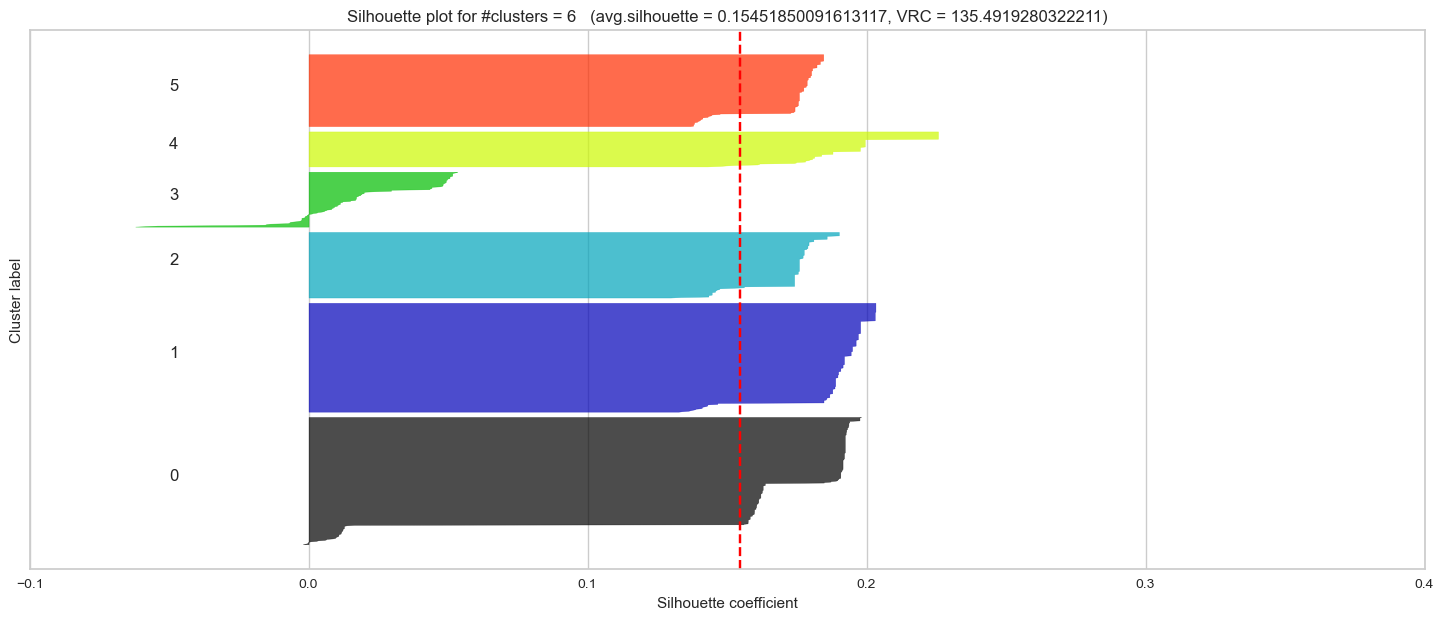

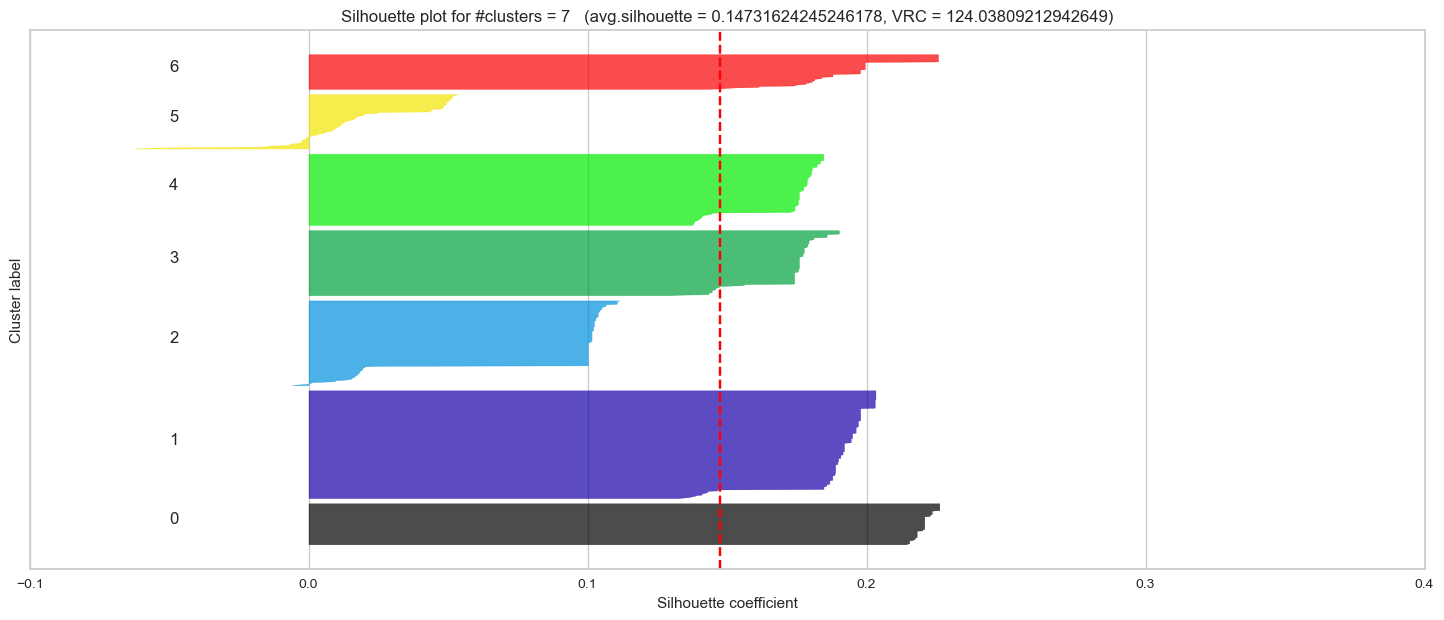

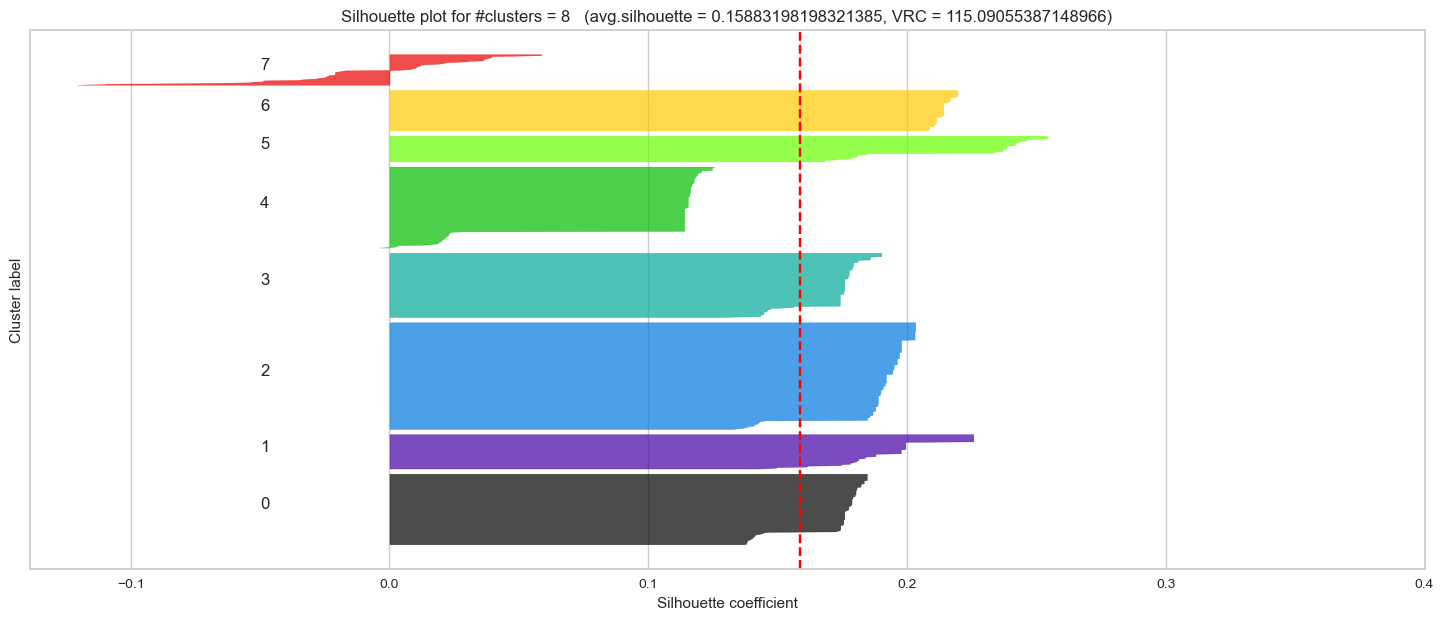

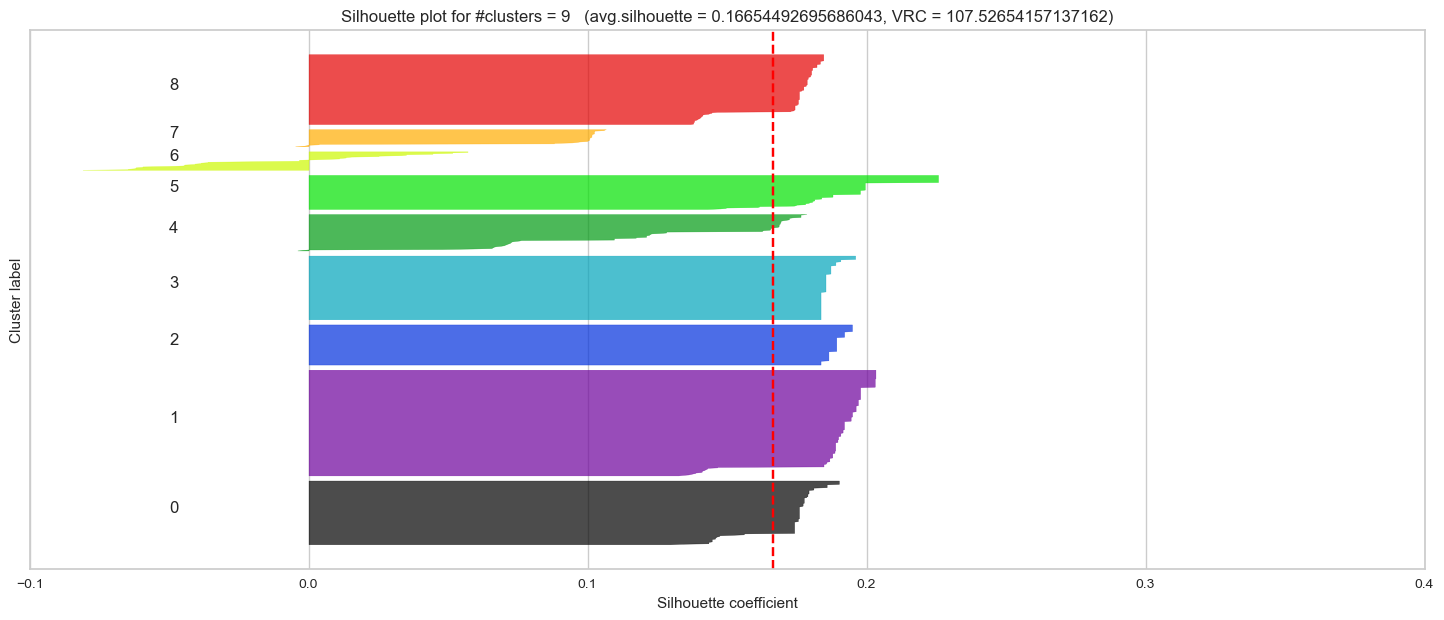

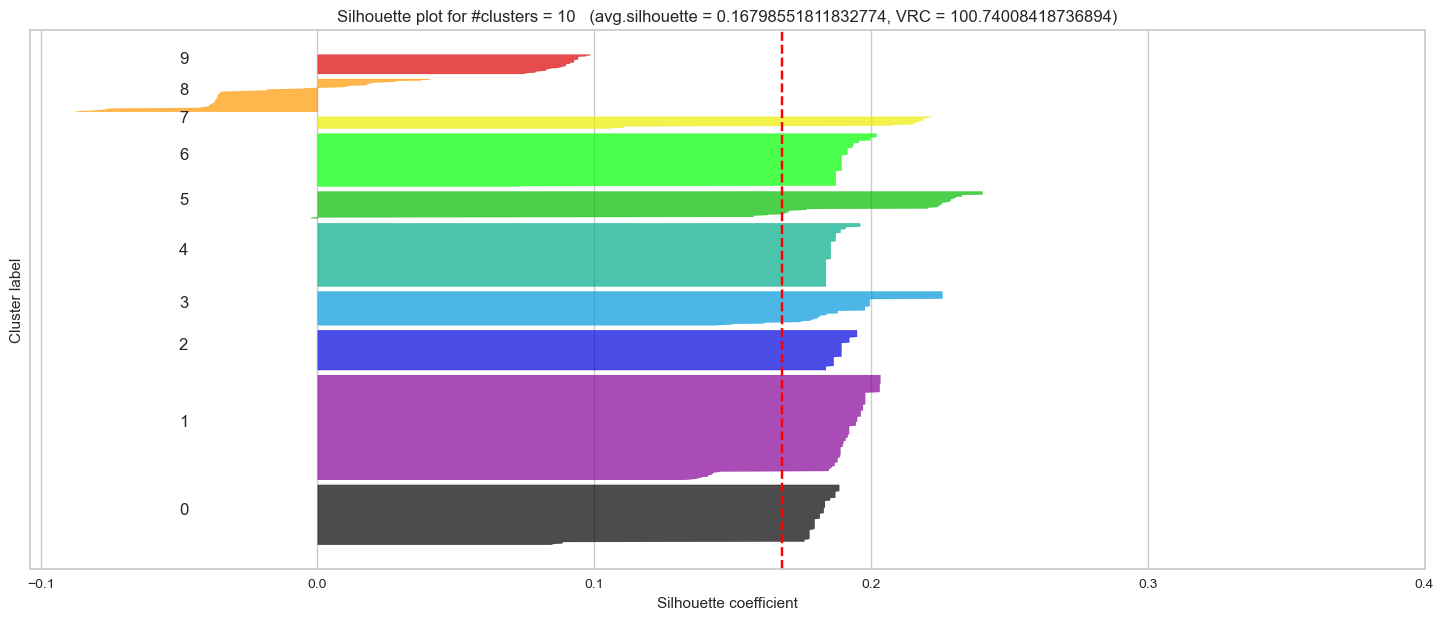

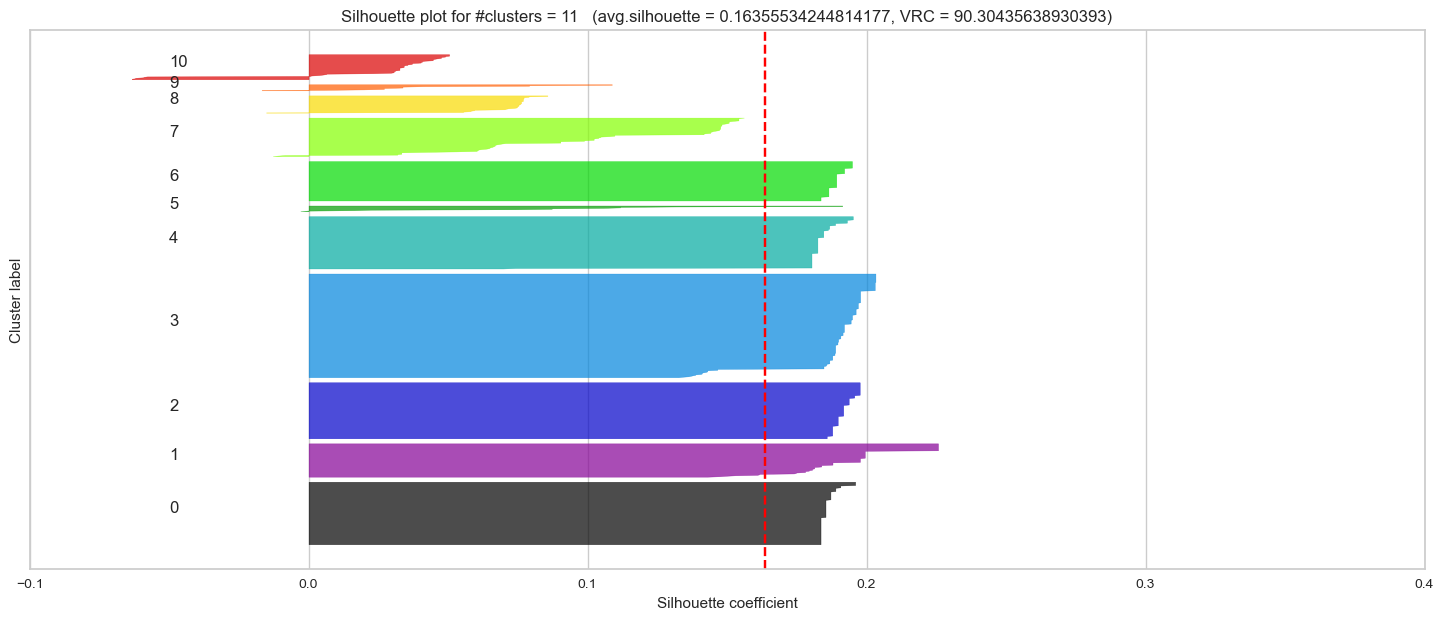

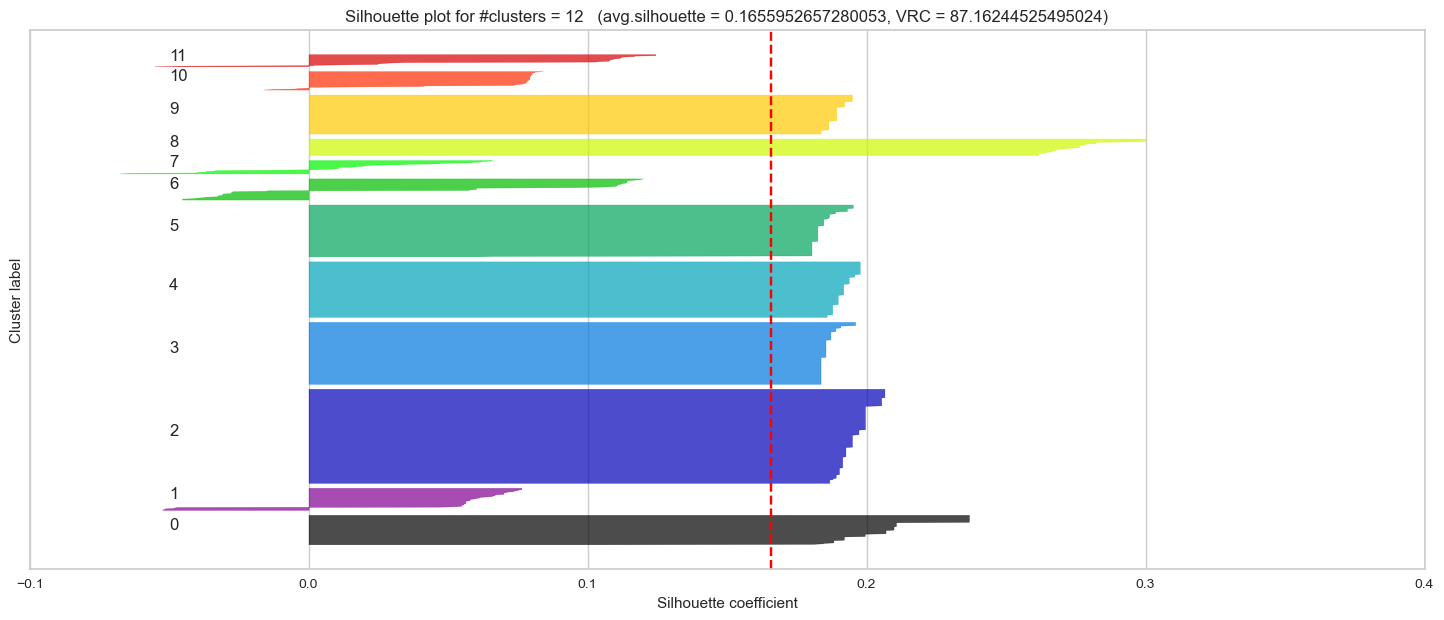

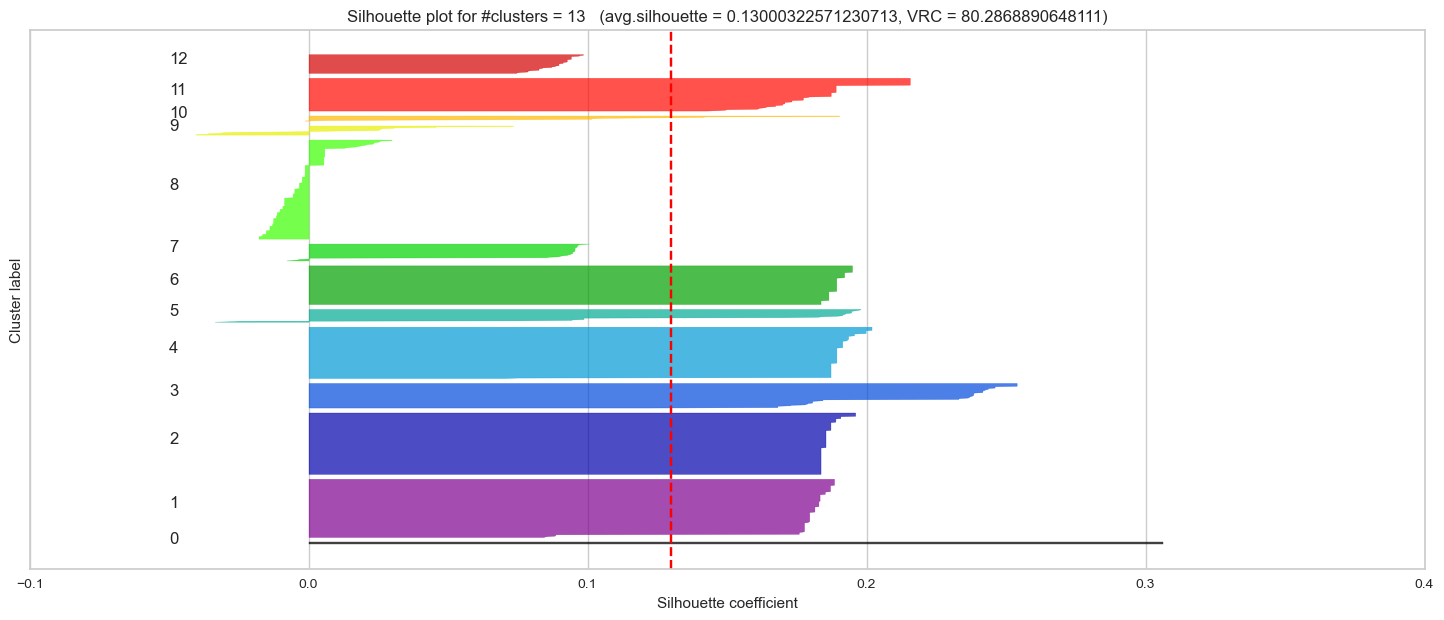

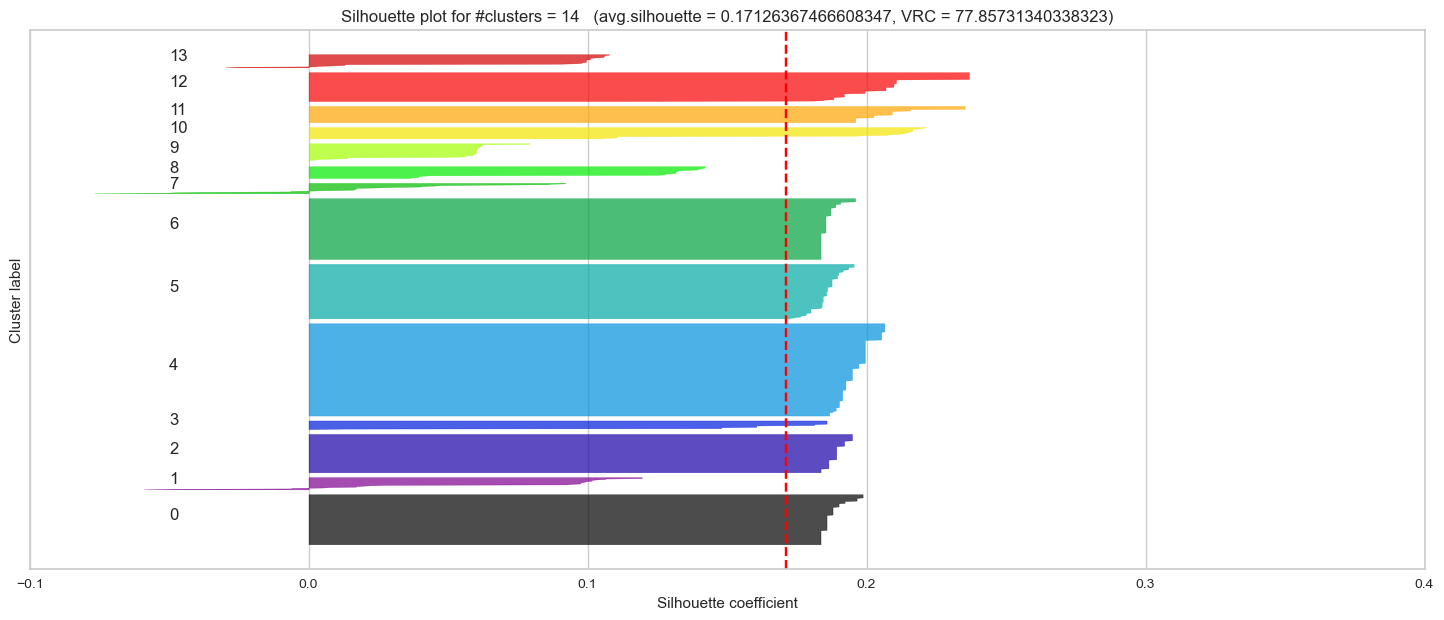

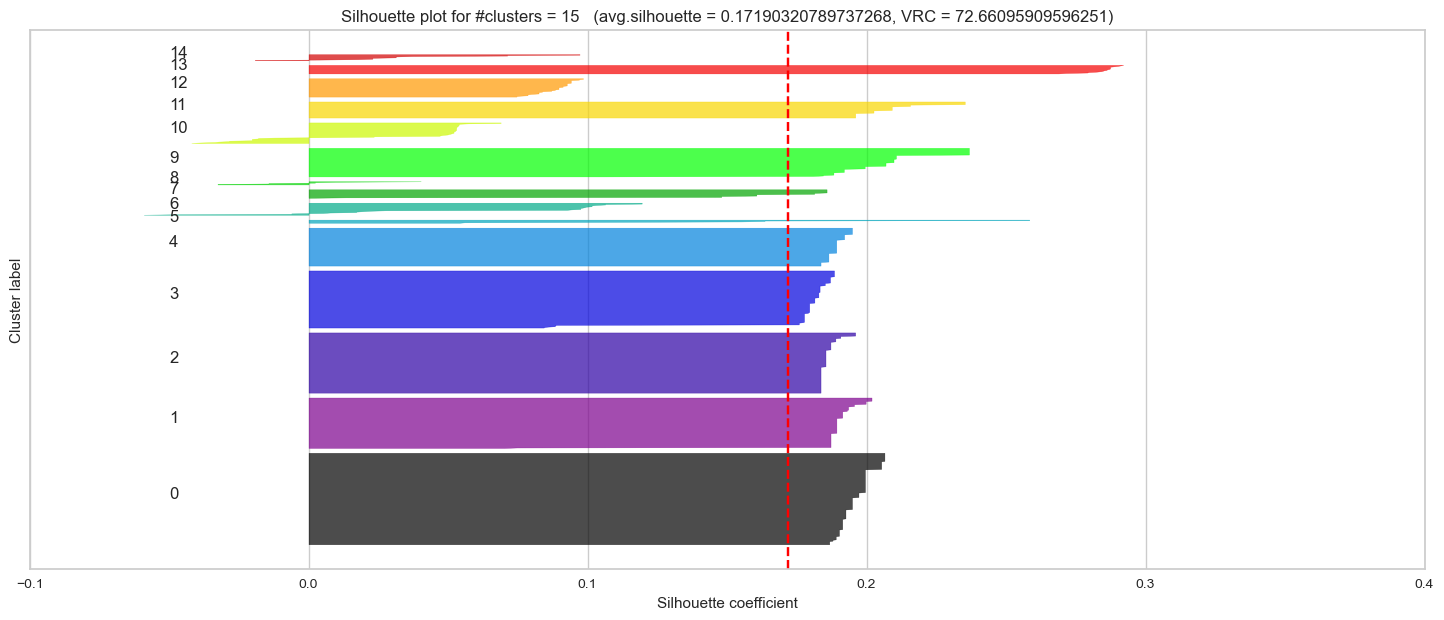

In [21]:
#   2.0.5 - Silhouette Analysis

def kmeans_clusterN(data, clustersNrange, plotting=True, random_state=None):
    '''
    Function to silhouette analyze K-means clustered data
    '''
    X = data.toarray()

    sAvgs = []
    vrcs = []
    for n_clusters in clustersNrange:

        clusterer = skCl.KMeans(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = sk.metrics.silhouette_score(X, cluster_labels)
        sAvgs.append(silhouette_avg)

        vrc = sk.metrics.calinski_harabasz_score(X, cluster_labels)
        vrcs.append(vrc)

        sample_silhouette_values = sk.metrics.silhouette_samples(X, cluster_labels)
        
        if plotting:
            fig, (ax1) = mp.pyplot.subplots(1, 1)
            fig.set_size_inches(18, 7)

            y_lower = 10
            for i in range(n_clusters):
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
                ith_cluster_silhouette_values.sort()
                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = mp.cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7,)
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                y_lower = y_upper + 10
            
            ax1.set_title(f"Silhouette plot for #clusters = {n_clusters}   (avg.silhouette = {silhouette_avg}, VRC = {vrc})")
            ax1.set_xlabel("Silhouette coefficient")
            ax1.set_ylabel("Cluster label")
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
            
            mp.pyplot.show()
        
        else:
            print(f"#clusters = {n_clusters}: avg.silhouette = {silhouette_avg}, VRC = {vrc}")


kmeans_clusterN(nodesEncoding, range(2,16))

#### 2.1 – Attributes-based
Proceeding to actual node clustering, at first channels are indeed grouped based on their features only; the most reasonable method to apply is thus exactly K-means.


##### (K) – K-means
Applying this baseline method on nodes’ encoded attributes with a desired communities’ number of 2, a Region based clustering is unsurprisingly produced. In particular, the 384 Puglia offices are grouped together and apart from the 576 other nodes – all the 548 Lombardia ones included, producing a labeling which could practically be used as comparison in evaluating other clusterings’ Region-based splitting capacity.

In [24]:
#   2.1.1 - K-means on node attributes

bestNclusters = 2
randState = 42

Klabels = skCl.KMeans(n_clusters=bestNclusters, random_state=randState).fit_predict(nodesEncoding)
Klabels,Kclustering,Kpartition = LCP(labels=Klabels)

Nclusters,Cov,SCM,TS,Q,AC = clustering_evaluation(routesG, Kpartition, weight='Traffic')

clusteringsDF['Kmeans'] = Klabels
clusteringsQualityDF.loc[len(clusteringsQualityDF)] = {'ALGORITHM':'Kmeans','#Clusters':Nclusters,'Cov':Cov,'SCM':SCM,'TS':TS,'Q':Q,'AC':AC}

print("Kmeans correlation with the 'region' attribute:")
display(clusteringsDF[['Kmeans','regione','ID_CHANNEL']].groupby(['Kmeans','regione']).count().reset_index().rename(columns={'ID_CHANNEL':'#Nodes'}))

Clustering evaluation:
#Communities: 2
Coverage: 0.8218640214920439
Performance: 0.48173987660757733
Traffic-aware Perf.: 0.4804626167530429
Modularity: 0.30734261957921705
Avg.Conductance: 0.006769062334009972

Kmeans correlation with the 'region' attribute:


,Kmeans,regione,#Nodes
0,0,Basilicata,1
1,0,Campania,2
2,0,Emilia Romagna,5
3,0,Friuli Venezia Giulia,1
4,0,Lazio,10
5,0,Liguria,2
6,0,Lombardia,548
7,0,Piemonte,2
8,0,Sicilia,1
9,0,Toscana,3


#### 2.2 – Structure-based
Most of the theoretically examined algorithms are specifically intended for clustering of networks grounded on its edges’ framework. In particular, some of them rely on this information type only; their application on the graph structure in analysis is discussed in this section.

##### (ALP) – Asynchronous Label Propagation
Due to the sparse input network mainly depicting consolidated routes, Asynchronous Label Propagation’s outcome asserts the presence of a very high number of communities: k is auto-assessed to be 297 in the here examined execution instance, but only 2 of the resulting clusters comprise more than 10 channels. These groups indeed represent the core slightly-more interconnected components of Lombardia and Puglia sub-graphs, approximately including 500 and 60 channels respectively.

In [27]:
#   2.2.1 - Asynchronous Label Propagation

LPclustering = list(nx.community.asyn_lpa_communities(routesG, weight='Traffic', seed=randState))
LPlabels,LPclustering,LPpartition = LCP(clustering=LPclustering)

Nclusters,Cov,SCM,TS,Q,AC = clustering_evaluation(routesG, LPpartition, weight='Traffic')

clusteringsDF['AsyncLP'] = LPlabels
clusteringsQualityDF.loc[len(clusteringsQualityDF)] = {'ALGORITHM':'AsyncLP','#Clusters':Nclusters,'Cov':Cov,'SCM':SCM,'TS':TS,'Q':Q,'AC':AC}

Clustering evaluation:
#Communities: 297
Coverage: 0.8325067162636909
Performance: 0.6203478015293709
Traffic-aware Perf.: 0.6189611702666493
Modularity: 0.06732610474727854
Avg.Conductance: 0.00421941131611748



##### (L) – Louvain
This Q-maximization method does not require a determined k too, but a parameter is specifiable to favor either larger or smaller clusters: a resolution higher than the default one (i.e., 1) would promote narrow communities’ creation, while a lower value would foster the partitioning in wider clusters. For this reason, after a default execution at standard parameters – leading to about 20 communities, resolution is set to 0.1 in order to achieve a k more comparable to the other strategies’ ones – obtaining 10 clusters in the reported LR-L case.

In [29]:
#   2.2.2 - Louvain

Lclustering = nx.community.louvain_communities(routesG, weight='Traffic', seed=randState)
Llabels,Lclustering,Lpartition = LCP(clustering=Lclustering)

Nclusters,Cov,SCM,TS,Q,AC = clustering_evaluation(routesG, Lpartition, weight='Traffic')

clusteringsDF['Louvain'] = Llabels
clusteringsQualityDF.loc[len(clusteringsQualityDF)] = {'ALGORITHM':'Louvain','#Clusters':Nclusters,'Cov':Cov,'SCM':SCM,'TS':TS,'Q':Q,'AC':AC}

Clustering evaluation:
#Communities: 23
Coverage: 0.6484810911345319
Performance: 0.8193745655196385
Traffic-aware Perf.: 0.817556546751787
Modularity: 0.4467230970757034
Avg.Conductance: 0.07783226306948517



In [30]:
#   2.2.3 - Low-Resolution Louvain

LRLclustering = nx.community.louvain_communities(routesG, weight='Traffic', resolution=0.1, seed=randState)
LRLlabels,LRLclustering,LRLpartition = LCP(clustering=LRLclustering)

Nclusters,Cov,SCM,TS,Q,AC = clustering_evaluation(routesG, LRLpartition, weight='Traffic')

clusteringsDF['LR-Louvain'] = LRLlabels
clusteringsQualityDF.loc[len(clusteringsQualityDF)] = {'ALGORITHM':'LR-Louvain','#Clusters':Nclusters,'Cov':Cov,'SCM':SCM,'TS':TS,'Q':Q,'AC':AC}

Clustering evaluation:
#Communities: 10
Coverage: 0.7842529448233106
Performance: 0.718970498783455
Traffic-aware Perf.: 0.7175109904643083
Modularity: 0.4586668403946187
Avg.Conductance: 0.09446152440338895



##### (GN) – Girvan-Newman
The Girvan-Newman algorithm is firstly executed with a fixed clusters’ number of 2, returning the community division derived from the graph’s first disconnection by iterative betweenness-based edge removals. Afterwards, the process is allowed to run and realize the typical hierarchical analysis until the Modularity peak is reached, outputting a partition in 13 clusters (F-GN). In both cases, the Q calculation is based on edges’ traffic and the betweenness computations on the inverse of the same value, intended by the latter function as specific ‘distance’ of the nodes connected by each edge. In fact, routes’ sections presenting a higher number of package transfers are assumed to be both the most crucial – attempting to keep them as in-cluster edges, and the logistically-elected most efficient paths – to be conceived as higher betweenness connections.

In [32]:
#   2.2.4 - Girvan-Newman

def Girvan_Newman(G, maxCommunities = 0, weight = None, betweenness_weigth = None):
    '''
    Function to run Girvan-Newman on G until maxCommunities is reached or Q starts decreasing
    '''
    def most_central_edge(G):
        centrality = nx.edge_betweenness_centrality(G, weight=betweenness_weigth)
        return max(centrality, key=centrality.get)    
    comp = nx.community.girvan_newman(G,most_valuable_edge=most_central_edge)
    
    clusterings = {}
    modularity,prev_modularity = -1,-2

    while modularity > prev_modularity:
        communities = next(comp)
        prev_modularity = modularity
        modularity = nx.community.modularity(G, communities, weight=weight)
        clusterings[len(communities)] = (modularity, tuple(sorted(c) for c in communities))
        if len(communities) == maxCommunities:
            break
    
    if modularity <= prev_modularity:
        bestClustering = clusterings[len(clusterings)]
        labels = np.array([cluster for node in G.nodes() for cluster in range(len(bestClustering[1])) if node in bestClustering[1][cluster]])
    else:
        bestClustering = clusterings[len(clusterings)+1]
        labels = np.array([cluster for node in G.nodes() for cluster in range(len(bestClustering[1])) if node in bestClustering[1][cluster]])

    return clusterings,bestClustering,labels


GNclusterings,GNbestClustering,GNlabels = Girvan_Newman(routesG,bestNclusters,'Traffic','InvTraffic')
GNlabels,GNclustering,GNpartition = LCP(labels=GNlabels)

Nclusters,Cov,SCM,TS,Q,AC = clustering_evaluation(routesG, GNpartition, weight='Traffic')

clusteringsDF['GirvanNewman'] = GNlabels
clusteringsQualityDF.loc[len(clusteringsQualityDF)] = {'ALGORITHM':'GirvanNewman','#Clusters':Nclusters,'Cov':Cov,'SCM':SCM,'TS':TS,'Q':Q,'AC':AC}

Clustering evaluation:
#Communities: 2
Coverage: 0.9835709857408556
Performance: 0.13664515988877302
Traffic-aware Perf.: 0.1367942362014273
Modularity: -0.00013341350101070263
Avg.Conductance: 0.5010744797945385



In [33]:
#   2.2.5 - Free Girvan-Newman

GNFclusterings,GNFbestClustering,GNFlabels = Girvan_Newman(routesG,0,'Traffic','InvTraffic')
GNFlabels,GNFclustering,GNFpartition = LCP(labels=GNFlabels)

Nclusters,Cov,SCM,TS,Q,AC = clustering_evaluation(routesG, GNFpartition, weight='Traffic')

clusteringsDF['GNFree'] = GNFlabels
clusteringsQualityDF.loc[len(clusteringsQualityDF)] = {'ALGORITHM':'GNFree','#Clusters':Nclusters,'Cov':Cov,'SCM':SCM,'TS':TS,'Q':Q,'AC':AC}

Clustering evaluation:
#Communities: 13
Coverage: 0.7386856788592684
Performance: 0.7732523027459158
Traffic-aware Perf.: 0.7747060034577141
Modularity: 0.015039179966485076
Avg.Conductance: 0.8423221006441413



##### (SF) – Spectral Filtering
The dimensionality-reduction strategy is applied on the original connectivity data; then, K-means is executed on the resulting embeddings with a pre-determined communities’ number of 2.

In [35]:
#   2.2.6 - Spectral Filtering

def spectral_clustering (G,k):
    '''
    Function to run Spectral Clustring in k communities on G
    '''
    X = sp.sparse.csr_matrix(nx.adjacency_matrix(G))
    clusterization = skCl.SpectralClustering(n_clusters=k,affinity='precomputed',assign_labels='kmeans', random_state=randState).fit(X)
    clustering = tuple([[num for num in G.nodes() if clusterization.labels_[num]==cluster] for cluster in range(k)])

    return LCP(clustering=clustering)


Slabels,Sclustering,Spartition = spectral_clustering(routesMultiG,bestNclusters)

Nclusters,Cov,SCM,TS,Q,AC = clustering_evaluation(routesG, Spartition, weight='Traffic')

clusteringsDF['Spectral'] = Slabels
clusteringsQualityDF.loc[len(clusteringsQualityDF)] = {'ALGORITHM':'Spectral','#Clusters':Nclusters,'Cov':Cov,'SCM':SCM,'TS':TS,'Q':Q,'AC':AC}

Clustering evaluation:
#Communities: 2
Coverage: 0.5115726389749948
Performance: 0.47961961244351753
Traffic-aware Perf.: 0.4797271660781089
Modularity: 0.01022022580277751
Avg.Conductance: 0.06784751845944609



##### (DW) – DeepWalk
As a final clustering strategy grounded on structure only, this representation learning method is applied on the routesG framework information; then, K-means is run on the resulting embeddings with a fixed k of 2.

In [37]:
#   2.2.7 - Deepwalk [https://github.com/phanein/deepwalk]

# Data preparation
nx.write_edgelist(routesMultiG, 'Deepwalk/Data/routesMultiG.edgelist', data=False)

# Representation learning alorithm (run in local machine)
'''
# Initialization:
python3.11 -m venv DWenv
DWenv\Scripts\activate
cd Deepwalk
python -m pip install -r requirements.txt
python setup.py install
pip install scipy==1.10.1
cd ..
deactivate
#(Note: collections->collections.abc module importing sometimes substituted)

# Deepwalk:
DWenv\Scripts\activate
cd Deepwalk
deepwalk --format edgelist --input Data/routesMultiG.edgelist --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 --workers 4 --output Data/routesMultiG.embeddings
'''

# Embeddings-based K-means clustering
DembeddingsDF = pd.read_csv('Deepwalk/Data/routesMultiG.embeddings', sep = ' ', header= None, index_col=0, skiprows=[0])

Dlabels = skCl.KMeans(n_clusters=bestNclusters, random_state=randState).fit(DembeddingsDF).labels_
Dlabels,Dclustering,Dpartition = LCP(labels=Dlabels)

Nclusters,Cov,SCM,TS,Q,AC = clustering_evaluation(routesG, Dpartition, weight='Traffic')

clusteringsDF['Deepwalk'] = Dlabels
clusteringsQualityDF.loc[len(clusteringsQualityDF)] = {'ALGORITHM':'Deepwalk','#Clusters':Nclusters,'Cov':Cov,'SCM':SCM,'TS':TS,'Q':Q,'AC':AC}

Clustering evaluation:
#Communities: 2
Coverage: 0.51828890266584
Performance: 0.5004898766075774
Traffic-aware Perf.: 0.5006279719234252
Modularity: 0.012289138659119986
Avg.Conductance: 0.06520216388637443



#### 2.3 – Deep graph clustering
The last two hereafter discussed algorithms attempt a deeper understanding of the input network, considering both its interconnectivity structure and nodes’ features at once. In the below applied algorithms’ cases, the embeddings’ quality largely depends on a wise choice of input parameters. Therefore, these variables are selected by tuning over multiple test-executions, with the aim of progressively maximizing the resulting clustering’s scores; the best obtained partitions are thus reported only.

##### (TADW) – Text-Associated DeepWalk
Through this method, random-walk-based representation learning is applied on the analyzed network as a whole; then, K-means is run on the resulting representation with a fixed k of 2.

In [40]:
#   2.3.1 - TADW [https://github.com/benedekrozemberczki/TADW]

# Data preparation
with open('TADW/Data/routesMultiG_edges.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['source', 'target'])
    for edge in list(routesMultiG.edges()):
        writer.writerow(edge)

nodesEncodingDF.to_csv('TADW/Data/routesMultiG_features.csv', index=False)

# Representation learning alorithm (run in local machine)
'''
# Initialization:
python3.12 -m venv TADWenv
TADWenv\Scripts\activate
python -m pip install networkx
python -m pip install tqdm
python -m pip install numpy
python -m pip install pandas
python -m pip install texttable
python -m pip install scipy
python -m pip install argparse
deactivate

# TADW:
TADWenv\Scripts\activate
cd TADW
python src/main.py --edge-path Data/routesMultiG_edges.csv --feature-path Data/routesMultiG_features.csv --output-path Data/routesMultiG_tadw.csv --features dense
'''

# Embeddings-based K-means clustering
TADWembeddingsDF = pd.read_csv('TADW/Data/routesMultiG_tadw.csv')

TADWlabels = skCl.KMeans(n_clusters=bestNclusters, random_state=randState).fit(TADWembeddingsDF).labels_
TADWlabels,TADWclustering,TADWpartition = LCP(labels=TADWlabels)

Nclusters,Cov,SCM,TS,Q,AC = clustering_evaluation(routesG, TADWpartition, weight='Traffic')

clusteringsDF['TADW'] = TADWlabels
clusteringsQualityDF.loc[len(clusteringsQualityDF)] = {'ALGORITHM':'TADW','#Clusters':Nclusters,'Cov':Cov,'SCM':SCM,'TS':TS,'Q':Q,'AC':AC}

Clustering evaluation:
#Communities: 2
Coverage: 0.895019632155404
Performance: 0.5007201511991658
Traffic-aware Perf.: 0.5009821975205931
Modularity: -0.002597271318091692
Avg.Conductance: 0.46656238125514077



##### (DCRN) – Dual Correlation Reduction Network
Finally, this highly NN-based algorithm is executed to generate another deep graph’s representation; then, K-means is executed on the results with a pre-determined communities’ number of 2.

In [42]:
#   2.3.2 - DCRN [https://github.com/yueliu1999/DCRN]

# Data preparation
with open('DCRN/dataset/routesG/routesG_adj.npy', 'wb') as f:
    np.save(f, nx.adjacency_matrix(routesG,weight='Traffic').todense())

with open('DCRN/dataset/routesG/routesG_feat.npy', 'wb') as f:
    np.save(f, regEncoding.todense())

with open('DCRN/dataset/routesG/routesG_label.npy', 'wb') as f:
    np.save(f, regLabels)

# Representation learning alorithm (run in local machine)
'''
# Initialization:
python3.11 -m venv DCRNenv
DCRNenv\Scripts\activate
python -m pip install --upgrade pip
python -m pip install --upgrade setuptools wheel
echo BUILDING WITH CUDA===cu117 AND TORCH===2.0.0
python -m pip install torch==2.0.0+cu117 torchvision==0.15.0+cu117 torchaudio==2.0.0 --extra-index-url https://download.pytorch.org/whl/cu117
python -m pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.0.0+cpu.html
python -m pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.0.0+cpu.html
python -m pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.0.0+cpu.html
python -m pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.0.0+cpu.html
python -m pip install torch-geometric
python -m pip install numpy==1.26.4
python
import torch
print(torch.__version__)
import torch_scatter
import torch_sparse
import torch_cluster
import torch_spline_conv
import torch_geometric
exit()
python -m pip install munkres
python -m pip install -U scikit-learn
deactivate

# DCRN-pretrain:
DCRNenv\Scripts\activate
cd DCRN/DCRN_pretrain
python pretrain_ae/main.py --name routesG
python pretrain_gae/main.py --name routesG
python pretrain/main.py --name routesG
cd ..
cd ..
deactivate

# DCRN:
DCRNenv\Scripts\activate
cd DCRN
python main.py --name routesG --seed 3 --alpha_value 0.2 --lambda_value 10 --gamma_value 1e3 --lr 1e-4
#(Note: graph parameters and labels saving added)
'''

# Embeddings-based K-means clustering
with open('DCRN/dataset/routesG/routesG_clusters.pkl', 'rb') as f:
    DCRNlabels = pkl.load(f)

DCRNlabels,DCRNclustering,DCRNpartition = LCP(labels=DCRNlabels)

Nclusters,Cov,SCM,TS,Q,AC = clustering_evaluation(routesG, DCRNpartition, weight='Traffic')

clusteringsDF['DCRN'] = DCRNlabels
clusteringsQualityDF.loc[len(clusteringsQualityDF)] = {'ALGORITHM':'DCRN','#Clusters':Nclusters,'Cov':Cov,'SCM':SCM,'TS':TS,'Q':Q,'AC':AC}

Clustering evaluation:
#Communities: 2
Coverage: 0.48822070675759455
Performance: 0.12331530239833159
Traffic-aware Perf.: 0.12379316160648542
Modularity: -0.12002286820151124
Avg.Conductance: 0.17299665581803908



### 3 – Outcomes analysis
In this section, the obtained partitions’ properties are discussed, assessing each clustering’s quality, the related algorithms’ performance on routesG, and on similarly structured graphs consequently.

#### 3.1 – Clusterings’ quality
To examine the various strategies’ outputs at first, the structure-based scores are to be considered.

In [76]:
#   3.1.1 - Clusterings' quality summary

print("\nMethods' performance metrics:")
display(clusteringsQualityDF)


Methods' performance metrics:


,ALGORITHM,#Clusters,Cov,SCM,TS,Q,AC
0,Kmeans,2,0.821864,0.481740,0.480463,0.307343,0.006769
1,AsyncLP,297,0.832507,0.620348,0.618961,0.067326,0.004219
2,Louvain,23,0.648481,0.819375,0.817557,0.446723,0.077832
3,LR-Louvain,10,0.784253,0.718970,0.717511,0.458667,0.094462
4,GirvanNewman,2,0.983571,0.136645,0.136794,-0.000133,0.501074
5,GNFree,13,0.738686,0.773252,0.774706,0.015039,0.842322
6,Spectral,2,0.511573,0.479620,0.479727,0.010220,0.067848
7,Deepwalk,2,0.518289,0.500490,0.500628,0.012289,0.065202
8,TADW,2,0.895020,0.500720,0.500982,-0.002597,0.466562
9,DCRN,2,0.488221,0.123315,0.123793,-0.120023,0.172997


The Louvain method seems the best performing one from a network’s framework perspective: it obtained significant results in favoring intra-cluster connectivity over inter-cluster one, coherently reaching good scores over all the above metrics and excelling in Coverage and Modularity maximization – at standard and low resolution parameter setting respectively. K-means is the only other algorithm boasting a satisfactory performance, with suitable results in all the metric types – despite a considerable drop at Cov’s normalization; on these data, an evaluation of nodes’ attributes would indeed lead to a sensible partition also form the network perspective, since the vertices are already strongly polarized towards shipping’s start and end Regions.

On the other hand, with its hyper-divisive outcome, Label Propagation obviously achieve a perfectly low Average Conductance and significantly high Coverage-related scores, while failing to reach a satisfactory Modularity – being Q normalized by random-clustering results’ expectation; a similarly contradictory scores distribution is noticeable for Spectral Filtering. The Girvan-Newman strategy, instead, displays unfulfilling results in both Q and AC, reaching a very low Modularity peak during iterative execution and an inconsistently high non-normalized Coverage after the first disconnection step; this prefigures the inability of any method based on edges’ centrality in operating sensible partitioning on this specific network.

Finally, the clusterings grounded on representation learning algorithms fail to fulfill Modularity’s requirements, with considerable GCN’s misinterpretation of the graph in analysis. Despite their unweighted perception of edges in the executed instances, DeepWalk-based methods seem slightly better performing; in particular, adding nodes’ features to embedding procedures lead to substantially worse network interpretations, as identifiable through the substantial AC drop and non-normalized Coverage burst between DW and TADW.

#### 3.2 – Algorithms comparison
A second evaluation step would involve the direct comparison among the presented methods, this could be achieved by computing the label-based scores between the clustering-obtained labels.

In [48]:
#   3.2.1 - Algorithms overall comparison

algorithms = list(clusteringsQualityDF['ALGORITHM'].unique())
algCouples = [(a1,a2) for i,a1 in enumerate(algorithms) for a2 in algorithms[i+1:]]
algCouples = algCouples+[(a2,a1) for a1,a2 in algCouples]+[(a,a) for a in algorithms]
compMeasures = ['Acc','J','FM','ARI','NMI','F1']
clusteringsComparisonDFs = {compMeasure:pd.DataFrame(columns=['ALGORITHM']+algorithms,index=range(len(algorithms))) for compMeasure in compMeasures}

for compMeasure in compMeasures:
    clusteringsComparisonDFs[compMeasure]['ALGORITHM'] = algorithms

for a1,a2 in algCouples:
    Evaluations = classification_evaluation(routesG, LCP(labels=list(clusteringsDF[a1]))[2], LCP(labels=list(clusteringsDF[a2]))[2], weight = 'Traffic', IO=False)
    for compMeasure in compMeasures:
        clusteringsComparisonDFs[compMeasure].at[algorithms.index(a1),a2] = Evaluations[compMeasures.index(compMeasure)]

for compMeasure in compMeasures:
    print(f"{compMeasure}-based comparison:")
    display(clusteringsComparisonDFs[compMeasure])

Acc-based comparison:


,ALGORITHM,Kmeans,AsyncLP,Louvain,LR-Louvain,GirvanNewman,GNFree,Spectral,Deepwalk,TADW,DCRN
0,Kmeans,1.0,0.595833,0.032292,0.167708,0.5875,0.221875,0.491667,0.513542,0.4875,0.584375
1,AsyncLP,0.595833,1.0,0.003125,0.165625,0.56875,0.227083,0.251042,0.310417,0.308333,0.570833
2,Louvain,0.032292,0.003125,1.0,0.004167,0.034375,0.039583,0.034375,0.035417,0.033333,0.035417
3,LR-Louvain,0.167708,0.165625,0.004167,1.0,0.222917,0.211458,0.279167,0.263542,0.266667,0.20625
4,GirvanNewman,0.5875,0.56875,0.034375,0.222917,1.0,0.369792,0.4125,0.523958,0.552083,0.867708
5,GNFree,0.221875,0.227083,0.039583,0.211458,0.369792,1.0,0.171875,0.216667,0.304167,0.354167
6,Spectral,0.491667,0.251042,0.034375,0.279167,0.4125,0.171875,1.0,0.492708,0.45,0.405208
7,Deepwalk,0.513542,0.310417,0.035417,0.263542,0.523958,0.216667,0.492708,1.0,0.584375,0.50625
8,TADW,0.4875,0.308333,0.033333,0.266667,0.552083,0.304167,0.45,0.584375,1.0,0.534375
9,DCRN,0.584375,0.570833,0.035417,0.20625,0.867708,0.354167,0.405208,0.50625,0.534375,1.0


J-based comparison:


,ALGORITHM,Kmeans,AsyncLP,Louvain,LR-Louvain,GirvanNewman,GNFree,Spectral,Deepwalk,TADW,DCRN
0,Kmeans,1.0,0.424332,0.016411,0.091529,0.415929,0.12478,0.325967,0.34548,0.322314,0.412804
1,AsyncLP,0.424332,1.0,0.001565,0.09029,0.39738,0.128085,0.143538,0.183724,0.182266,0.399417
2,Louvain,0.016411,0.001565,1.0,0.002088,0.017488,0.020191,0.017488,0.018028,0.016949,0.018028
3,LR-Louvain,0.091529,0.09029,0.002088,1.0,0.12544,0.118229,0.162228,0.15177,0.153846,0.114983
4,GirvanNewman,0.415929,0.39738,0.017488,0.12544,1.0,0.226837,0.259843,0.354975,0.381295,0.766329
5,GNFree,0.12478,0.128085,0.020191,0.118229,0.226837,1.0,0.094017,0.121495,0.179361,0.21519
6,Spectral,0.325967,0.143538,0.017488,0.162228,0.259843,0.094017,1.0,0.326883,0.290323,0.254082
7,Deepwalk,0.34548,0.183724,0.018028,0.15177,0.354975,0.121495,0.326883,1.0,0.412804,0.338912
8,TADW,0.322314,0.182266,0.016949,0.153846,0.381295,0.179361,0.290323,0.412804,1.0,0.364606
9,DCRN,0.412804,0.399417,0.018028,0.114983,0.766329,0.21519,0.254082,0.338912,0.364606,1.0


FM-based comparison:


,ALGORITHM,Kmeans,AsyncLP,Louvain,LR-Louvain,GirvanNewman,GNFree,Spectral,Deepwalk,TADW,DCRN
0,Kmeans,1.0,0.806708,0.559108,0.670563,0.670653,0.339584,0.51879,0.509268,0.509206,0.674347
1,AsyncLP,0.806708,1.0,0.395265,0.397228,0.574749,0.288755,0.441166,0.435471,0.435744,0.574869
2,Louvain,0.559108,0.395265,1.0,0.762364,0.392013,0.195817,0.309576,0.300657,0.301428,0.398172
3,LR-Louvain,0.670563,0.397228,0.762364,1.0,0.492735,0.255167,0.384851,0.375342,0.3748,0.498712
4,GirvanNewman,0.670653,0.574749,0.392013,0.492735,1.0,0.511709,0.670738,0.657944,0.6612,0.868086
5,GNFree,0.339584,0.288755,0.195817,0.255167,0.511709,1.0,0.340626,0.342085,0.505971,0.438414
6,Spectral,0.51879,0.441166,0.309576,0.384851,0.670738,0.340626,1.0,0.509427,0.514222,0.67719
7,Deepwalk,0.509268,0.435471,0.300657,0.375342,0.657944,0.342085,0.509427,1.0,0.513234,0.661901
8,TADW,0.509206,0.435744,0.301428,0.3748,0.6612,0.505971,0.514222,0.513234,1.0,0.663627
9,DCRN,0.674347,0.574869,0.398172,0.498712,0.868086,0.438414,0.67719,0.661901,0.663627,1.0


ARI-based comparison:


,ALGORITHM,Kmeans,AsyncLP,Louvain,LR-Louvain,GirvanNewman,GNFree,Spectral,Deepwalk,TADW,DCRN
0,Kmeans,1.0,0.638071,0.302077,0.433266,0.001206,-0.004528,-0.002355,-0.000269,-0.000376,-0.002019
1,AsyncLP,0.638071,1.0,0.164427,0.102056,0.002733,-0.006258,-0.00636,-0.000532,-0.000041,-0.005155
2,Louvain,0.302077,0.164427,1.0,0.671698,-0.004422,-0.008553,0.002756,-0.000483,0.000453,-0.000862
3,LR-Louvain,0.433266,0.102056,0.671698,1.0,-0.001631,0.003282,0.00266,0.000014,-0.000789,0.001961
4,GirvanNewman,0.001206,0.002733,-0.004422,-0.001631,1.0,0.087607,-0.00006,0.001986,0.010572,-0.021992
5,GNFree,-0.004528,-0.006258,-0.008553,0.003282,0.087607,1.0,-0.003503,0.007801,0.228383,-0.009143
6,Spectral,-0.002355,-0.00636,0.002756,0.00266,-0.00006,-0.003503,1.0,-0.000789,0.00901,0.004375
7,Deepwalk,-0.000269,-0.000532,-0.000483,0.000014,0.001986,0.007801,-0.000789,1.0,0.027462,-0.000129
8,TADW,-0.000376,-0.000041,0.000453,-0.000789,0.010572,0.228383,0.00901,0.027462,1.0,0.004472
9,DCRN,-0.002019,-0.005155,-0.000862,0.001961,-0.021992,-0.009143,0.004375,-0.000129,0.004472,1.0


NMI-based comparison:


,ALGORITHM,Kmeans,AsyncLP,Louvain,LR-Louvain,GirvanNewman,GNFree,Spectral,Deepwalk,TADW,DCRN
0,Kmeans,1.0,0.346792,0.39505,0.473859,0.000071,0.005259,0.000473,0.000612,0.000477,0.000117
1,AsyncLP,0.346792,1.0,0.381674,0.270708,0.056681,0.265135,0.125606,0.126355,0.128754,0.050365
2,Louvain,0.39505,0.381674,1.0,0.732016,0.011764,0.058164,0.008898,0.005846,0.014171,0.010275
3,LR-Louvain,0.473859,0.270708,0.732016,1.0,0.0047,0.026452,0.005759,0.001386,0.005638,0.006491
4,GirvanNewman,0.000071,0.056681,0.011764,0.0047,1.0,0.240925,0.000002,0.011248,0.046321,0.001481
5,GNFree,0.005259,0.265135,0.058164,0.026452,0.240925,1.0,0.015269,0.023845,0.249503,0.018476
6,Spectral,0.000473,0.125606,0.008898,0.005759,0.000002,0.015269,1.0,0.000192,0.007659,0.000687
7,Deepwalk,0.000612,0.126355,0.005846,0.001386,0.011248,0.023845,0.000192,1.0,0.020641,0.001406
8,TADW,0.000477,0.128754,0.014171,0.005638,0.046321,0.249503,0.007659,0.020641,1.0,0.021598
9,DCRN,0.000117,0.050365,0.010275,0.006491,0.001481,0.018476,0.000687,0.001406,0.021598,1.0


F1-based comparison:


,ALGORITHM,Kmeans,AsyncLP,Louvain,LR-Louvain,GirvanNewman,GNFree,Spectral,Deepwalk,TADW,DCRN
0,Kmeans,1.0,0.635,0.71,0.8,0.645,0.42,0.54,0.51,0.51,0.645
1,AsyncLP,0.014242,1.0,0.036936,0.016599,0.005185,0.030537,0.006376,0.002367,0.002475,0.004899
2,Louvain,0.11913,0.152609,1.0,0.453913,0.073913,0.0708,0.067692,0.070345,0.069167,0.076087
3,LR-Louvain,0.237,0.255,0.906,1.0,0.153,0.110909,0.130909,0.103846,0.124545,0.16
4,GirvanNewman,0.43,0.435,0.295,0.345,1.0,0.785,0.43,0.42,0.455,0.535
5,GNFree,0.117692,0.116923,0.118125,0.12,0.2,1.0,0.111429,0.129286,0.191538,0.124615
6,Spectral,0.54,0.545,0.36,0.425,0.645,0.42,1.0,0.5,0.545,0.645
7,Deepwalk,0.545,0.55,0.37,0.425,0.65,0.425,0.545,1.0,0.585,0.655
8,TADW,0.545,0.55,0.375,0.43,0.65,0.67,0.545,0.585,1.0,0.655
9,DCRN,0.425,0.43,0.29,0.325,0.53,0.38,0.425,0.395,0.43,1.0


Differing only by the resolution parameter setting, the two Louvain executions’ outputs lead to very high values in every comparison metric apart from Acc and J; this might be due to an equal approach but different detected communities’ number. Besides directly explaining the significant difference between the two F1 scores – weighted by clusters’ size, the more-than-doubled k evidently makes Accuracy’s mapping arduous and leads a consistent part of the Jaccard-compared node couples to be split. A totally analogous situation is found when comparing K-means’ and Low-Resolution Louvain’s results. Similarly to what already noted for ALP vs K – here reaching constantly high values obviously except for the F1 weighted on ALP clusters’ sizes; LR-L produces an indeed highly Region-correlated partition, abstracting three Lombardia highly-connected components and quite sensibly dividing Puglia nodes from the others, as noticeable by the following crosstab.

On the other hand, despite sharing the same structural clustering strategy, the two DeepWalk-based algorithms (i.e., DW and TADW) produce well-balanced but totally different halves of the graphs’ nodes (distribution shown below), inducing medium scores in direct label-comparison measures but being overturned by randomicity-normalized ones. Many other methods comparisons fail to persevere from an NMI and ARI viewpoint even if well-scoring on the other metrics, but these cases are definitely doomed by the totally incoherent community sizes (illustrative crosstabs reported hereafter) proposed by either GN, DCRN or both – with the latter case even record-scoring at Acc, J, and FM.

In [50]:
#   3.2.2 - Specific resulting clusterings' comparison

print("\nComparison between Kmeans and ALP:")
display(pd.crosstab(index=clusteringsDF['Kmeans'],columns=clusteringsDF['AsyncLP']))
classification_evaluation(routesG, Kpartition, LPpartition, weight = 'Traffic')

print("\nComparison between Girvan-Newman and DCRN:")
display(pd.crosstab(index=clusteringsDF['GirvanNewman'],columns=clusteringsDF['DCRN']))
classification_evaluation(routesG, GNpartition, DCRNpartition, weight = 'Traffic')

print("\nComparison between Kmeans and Low-Resolution Louvain:")
display(pd.crosstab(index=clusteringsDF['Kmeans'],columns=clusteringsDF['LR-Louvain']))
classification_evaluation(routesG, Kpartition, LRLpartition, weight = 'Traffic')

print("\nComparison between Kmeans and Girvan-Newman:")
display(pd.crosstab(index=clusteringsDF['Kmeans'],columns=clusteringsDF['GirvanNewman']))
classification_evaluation(routesG, Kpartition, GNpartition, weight = 'Traffic')

print("\nComparison between Spectral and Girvan-Newman:")
display(pd.crosstab(index=clusteringsDF['Spectral'],columns=clusteringsDF['GirvanNewman']))
classification_evaluation(routesG, Spartition, GNpartition, weight = 'Traffic')

print("\nComparison between Spectral and DCRN:")
display(pd.crosstab(index=clusteringsDF['Spectral'],columns=clusteringsDF['DCRN']))
classification_evaluation(routesG, Spartition, DCRNpartition, weight = 'Traffic')

print("\nComparison between DeepWalk and TADW:")
display(pd.crosstab(index=clusteringsDF['Deepwalk'],columns=clusteringsDF['TADW']))
classification_evaluation(routesG, Dpartition, TADWpartition, weight = 'Traffic')


Comparison between Kmeans and ALP:


AsyncLP,0,1,2,3,4,5,6,7,8,9,...,287,288,289,290,291,292,293,294,295,296
Kmeans,,,,,,,,,,,,,,,,,,,,,
0,571,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17,1,1,1,1,66,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Classification evaluation:
Accuracy: 0.5958333333333333
Jaccard: 0.42433234421364985
Fowlkes-Mallows: 0.8067084047943025
Adj.RandIdx.: 0.6380712982008244
Norm.MutualInf.: 0.3467916218438996
F1-score: 0.635


Comparison between Girvan-Newman and DCRN:


DCRN,0,1
GirvanNewman,,
0,830,60
1,67,3


Classification evaluation:
Accuracy: 0.8677083333333333
Jaccard: 0.766329346826127
Fowlkes-Mallows: 0.8680855158589468
Adj.RandIdx.: -0.02199178178782086
Norm.MutualInf.: 0.0014812334575281523
F1-score: 0.535


Comparison between Kmeans and Low-Resolution Louvain:


LR-Louvain,0,1,2,3,4,5,6,7,8,9
Kmeans,,,,,,,,,,
0,161,295,0,67,16,2,13,17,2,3
1,38,0,2,1,343,0,0,0,0,0


Classification evaluation:
Accuracy: 0.16770833333333332
Jaccard: 0.09152927799886298
Fowlkes-Mallows: 0.6705627608287799
Adj.RandIdx.: 0.43326644911375795
Norm.MutualInf.: 0.4738588289294462
F1-score: 0.8


Comparison between Kmeans and Girvan-Newman:


GirvanNewman,0,1
Kmeans,,
0,535,41
1,355,29


Classification evaluation:
Accuracy: 0.5875
Jaccard: 0.415929203539823
Fowlkes-Mallows: 0.6706534404223391
Adj.RandIdx.: 0.001205807671130353
Norm.MutualInf.: 7.134578852914668e-05
F1-score: 0.645


Comparison between Spectral and Girvan-Newman:


GirvanNewman,0,1
Spectral,,
0,354,28
1,536,42


Classification evaluation:
Accuracy: 0.4125
Jaccard: 0.25984251968503935
Fowlkes-Mallows: 0.6707383425598867
Adj.RandIdx.: -5.9734891040911364e-05
Norm.MutualInf.: 1.525916942946357e-06
F1-score: 0.645


Comparison between Spectral and DCRN:


DCRN,0,1
Spectral,,
0,354,28
1,543,35


Classification evaluation:
Accuracy: 0.40520833333333334
Jaccard: 0.25408229915088176
Fowlkes-Mallows: 0.677189611149035
Adj.RandIdx.: 0.004375422170023105
Norm.MutualInf.: 0.0006866704662860083
F1-score: 0.645


Comparison between DeepWalk and TADW:


TADW,0,1
Deepwalk,,
0,279,198
1,201,282


Classification evaluation:
Accuracy: 0.584375
Jaccard: 0.41280353200883
Fowlkes-Mallows: 0.5132336920276042
Adj.RandIdx.: 0.027462485832199006
Norm.MutualInf.: 0.020641234132523497
F1-score: 0.585



(0.584375,
 0.41280353200883,
 0.5132336920276042,
 0.027462485832199006,
 0.020641234132523497,
 0.585)

### Conclusions
Considering the above practical analysis and the underlying theoretical groundings, Louvain algorithm’s strength effectively emerges in efficiently uncovering community structures at multiple levels: LR-L best understand routesG framework, probably by parallelly evaluating both geographical distribution and offices’ pyramidal order (i.e., from the most central hubs to the capillary delivery channels). Many clustering algorithms instead struggle when applied to sparse and sequential-steps networks. In fact, specific strategies and software are typically used both in the business and industrial sector when dealing with process-representing structures, focusing on the assessment of edges, routes sections, and only indirectly on nodes.

Considering the poor outcome of DCRN and the satisfactory results given by some simpler clustering algorithms (e.g., K-means and Louvain), it is inferable that deep Artificial Intelligence techniques are sometimes still less competent with respect to more human-guided algorithms in probing networks with peculiar frameworks and implied meanings. Surely bolstered by a restricted train dataset too, the apparent failure of NN-based representation learning methods seems to supply an additional instance in support of prominent theses highlighting these agents’ unstable clustering capacities, not in step with their level of rigor in executing other graph-analysis procedures.